In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import copy
import inspect
import pandas as pd
import matplotlib.pyplot as plt

import data_interface
import mnar_blackout_lds

random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Load the data
x_t, m_t, meta = data_interface.load_panel()

In [45]:
evaluation_windows = data_interface.get_eval_windows(
    data_dir="data",
)

In [46]:
from collections import defaultdict

def stratified_month_sampling(data, n_per_month, ts_key="blackout_start"):
    buckets = defaultdict(list)

    for item in data:
        ts = item[ts_key]
        month_key = (ts.year, ts.month)
        buckets[month_key].append(item)

    result = []
    for month_key, items in buckets.items():
        if len(items) < n_per_month:
            picks = random.choices(items, k=n_per_month)
        else:
            picks = random.sample(items, n_per_month)
        result.extend(picks)

    return result

In [47]:
# ------------------------------------------------------------------
# 1) Group evaluation windows by window_id and test_type/horizon
#    (handles cases where there are multiple rows per window_id).
# ------------------------------------------------------------------
impute_by_id = {}
forecast_1_by_id = {}
forecast_3_by_id = {}
forecast_6_by_id = {}

for w in evaluation_windows:
    wid = w["window_id"]
    if w["test_type"] == "impute":
        # If duplicates exist, last one wins – that's fine for eval.
        impute_by_id[wid] = w
    elif w["test_type"] == "forecast":
        h = int(w["horizon_steps"])
        if h == 1:
            forecast_1_by_id[wid] = w
        elif h == 3:
            forecast_3_by_id[wid] = w
        elif h == 6:
            forecast_6_by_id[wid] = w

In [48]:
# ------------------------------------------------------------------
# 2) Keep only window_ids that have impute + 1-step + 3-step + 6-step
# ------------------------------------------------------------------
common_ids = (
    set(impute_by_id.keys())
    & set(forecast_1_by_id.keys())
    & set(forecast_3_by_id.keys())
    & set(forecast_6_by_id.keys())
)

# Pool of impute windows that have all matching forecast horizons
impute_windows_pool = [impute_by_id[wid] for wid in common_ids]

In [49]:
# ------------------------------------------------------------------
# 3) Sample *validation* impute windows (stratified by month)
# ------------------------------------------------------------------
impute_evaluation_windows_val = stratified_month_sampling(
    impute_windows_pool,
    n_per_month=25,
    ts_key="blackout_start",
)

# Preserve order: we now build *aligned* forecast lists
val_ids_ordered = [w["window_id"] for w in impute_evaluation_windows_val]

forecast_1_evaluation_windows_val = [
    forecast_1_by_id[wid] for wid in val_ids_ordered
]
forecast_3_evaluation_windows_val = [
    forecast_3_by_id[wid] for wid in val_ids_ordered
]
forecast_6_evaluation_windows_val = [
    forecast_6_by_id[wid] for wid in val_ids_ordered
]

In [50]:
assert len(forecast_1_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_3_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_6_evaluation_windows_val) == len(impute_evaluation_windows_val)

# ------------------------------------------------------------------
# 4) Combined list used only for masking (deduped later)
# ------------------------------------------------------------------
evaluation_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
    + impute_evaluation_windows_val
)

In [51]:
# Time features for MNAR (T, F_time)
X_time = data_interface.build_time_features(meta["timestamps"])

#  detector-level features (D, F_det)
detector_features = None
try:
    Phi, feat_meta = data_interface.load_missingness_features("data")
    if "time_features" in feat_meta:
        X_time = feat_meta["time_features"]
    detector_features = feat_meta.get("detector_features", None)
except Exception:
    pass

In [52]:
def locf_impute_baseline(x_t, start_idx, end_idx, detector_idx):
    """
    Naive 'last observation carried forward' baseline for imputation.
    Uses the last finite value before blackout; falls back to
    detector-wise historical mean if needed.
    """
    last_idx = start_idx - 1
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    length = end_idx - start_idx + 1
    return np.full(length, last_val, dtype=float)


def locf_forecast_baseline(x_t, end_idx, detector_idx):
    """
    Naive baseline for forecasting: hold the last available observation
    at the end of the blackout.
    """
    last_idx = end_idx
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    return last_val


def evaluate_impute_forecast_model(
    model,
    mu_smooth,
    Sigma_smooth,
    mu_filt,
    Sigma_filt,
    x_t,
    meta,
    label="model",
    impute_windows=None,
    forecast_windows=None,
):
    """
    Re-usable evaluation for any LDS-like model (MAR or MNAR):
    - blackout imputation RMSE/MAE (length-weighted)
    - 1 / 3 / 6-step forecast RMSE/MAE
    """
    # ---------------- Imputation ----------------
    impute_mae_list = []
    impute_mse_list = []

    if impute_windows is None:
        impute_windows = impute_evaluation_windows_val

    for window in impute_windows:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx : end_idx + 1].copy()
        eval_mu_smooth = mu_smooth[start_idx : end_idx + 1]
        eval_Sigma_smooth = Sigma_smooth[start_idx : end_idx + 1]

        reconstruct_x_t, _ = model.reconstruct_from_smoother(
            eval_mu_smooth, eval_Sigma_smooth
        )

        y_true = eval_x_t[:, detector_idx]
        y_pred = reconstruct_x_t[:, detector_idx]

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------------- Forecasting ----------------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    if forecast_windows is None:
        forecast_windows = (
            forecast_1_evaluation_windows_val
            + forecast_3_evaluation_windows_val
            + forecast_6_evaluation_windows_val
        )

    for window in forecast_windows:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        # Skip windows too close to the end of the series
        if end_idx + horizon >= x_t.shape[0]:
            continue

        eval_x_t = x_t[end_idx + 1 : end_idx + 1 + horizon].copy()

        forecast_x_t, _ = model.k_step_forecast(
            mu_filt, Sigma_filt, end_idx, k=horizon
        )

        y_true = eval_x_t[horizon - 1, detector_idx]
        y_pred = forecast_x_t[detector_idx]

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [53]:
# ============================================================
# 1) Stronger baselines
#    - Linear interpolation inside blackout (uses pre + post points)
#    - Optional spline interpolation (falls back to linear)
#    - Seasonal naive for forecasting (same time yesterday / last week)
# ============================================================
def _find_last_finite(x: np.ndarray, idx: int, d: int) -> tuple[int, float] | tuple[None, None]:
    j = idx
    while j >= 0 and not np.isfinite(x[j, d]):
        j -= 1
    if j < 0:
        return None, None
    return j, float(x[j, d])


def _find_next_finite(x: np.ndarray, idx: int, d: int) -> tuple[int, float] | tuple[None, None]:
    j = idx
    T = x.shape[0]
    while j < T and not np.isfinite(x[j, d]):
        j += 1
    if j >= T:
        return None, None
    return j, float(x[j, d])


def linear_interp_impute_baseline(x_t_masked, start_idx, end_idx, detector_idx):
    """
    Impute a blackout [start_idx, end_idx] by linear interpolation between:
      left  = last finite before start
      right = first finite after end
    Falls back to LOCF if one side missing.
    """
    left_j, left_v = _find_last_finite(x_t_masked, start_idx - 1, detector_idx)
    right_j, right_v = _find_next_finite(x_t_masked, end_idx + 1, detector_idx)

    L = end_idx - start_idx + 1
    if left_v is None and right_v is None:
        # ultimate fallback: detector mean
        det_vals = x_t_masked[:, detector_idx]
        fill = float(np.nanmean(det_vals))
        return np.full(L, fill, dtype=float)
    if left_v is None:
        return np.full(L, right_v, dtype=float)
    if right_v is None:
        return np.full(L, left_v, dtype=float)

    # interpolate over actual index distance so long gaps are handled correctly
    xs = np.arange(start_idx, end_idx + 1)
    denom = max((right_j - left_j), 1)
    alpha = (xs - left_j) / denom
    return (1 - alpha) * left_v + alpha * right_v


def spline_impute_baseline(
    x_t_masked, start_idx, end_idx, detector_idx,
    order=3, context=288  # 1 day on 5-min grid
):
    """
    Local spline interpolation around the blackout only.
    Falls back to linear if spline fails or insufficient support.
    """
    try:
        T = x_t_masked.shape[0]
        a = max(0, start_idx - context)
        b = min(T, end_idx + context + 1)

        s = pd.Series(x_t_masked[a:b, detector_idx]).astype(float)

        # blackout region relative to the local slice
        s_rel = start_idx - a
        e_rel = end_idx - a
        s.iloc[s_rel:e_rel+1] = np.nan

        s = s.interpolate(method="spline", order=order, limit_direction="both")

        return s.iloc[s_rel:e_rel+1].to_numpy(dtype=float)
    except Exception:
        return linear_interp_impute_baseline(x_t_masked, start_idx, end_idx, detector_idx)


def seasonal_naive_forecast_baseline(x_t_masked, target_idx, detector_idx, offsets=(288, 2016)):
    """
    Forecast x[target_idx, d] using historical seasonal offsets:
      - 288 steps = 1 day back (5-min grid)
      - 2016 steps = 1 week back
    Falls back to LOCF at end of blackout if needed.
    """
    for off in offsets:
        j = target_idx - off
        if j >= 0 and np.isfinite(x_t_masked[j, detector_idx]):
            return float(x_t_masked[j, detector_idx])
    # fallback: last observed before target
    j, v = _find_last_finite(x_t_masked, target_idx - 1, detector_idx)
    if v is None:
        det_vals = x_t_masked[:, detector_idx]
        return float(np.nanmean(det_vals))
    return v

def build_hour_of_week_climatology(
    x_t_masked: np.ndarray,
    m_t_masked: np.ndarray,
    timestamps: np.ndarray,
    step_minutes: int = 5,
):
    """
    Builds time-of-week climatology: mean per (slot_of_week, detector).

    slot_of_week = dow * steps_per_day + step_in_day
    where step_in_day = (hour*60 + minute) // step_minutes

    Returns:
      how_mean: (S, D) array of means, S = 7 * steps_per_day
      slot_of_week: (T,) int array mapping each t -> slot index
      global_mean: (D,) detector-wise global mean fallback
    """
    ts = pd.to_datetime(timestamps)
    dow = ts.dayofweek.to_numpy()  # Mon=0
    minutes = (ts.hour.to_numpy() * 60 + ts.minute.to_numpy())

    steps_per_day = int((24 * 60) // step_minutes)
    step_in_day = (minutes // step_minutes).astype(int)
    # safety: if timestamps aren't aligned to step_minutes, clamp
    step_in_day = np.clip(step_in_day, 0, steps_per_day - 1)

    slot_of_week = (dow * steps_per_day + step_in_day).astype(int)
    S = 7 * steps_per_day
    T, D = x_t_masked.shape

    # observed mask: 1 where observed & finite
    obs = (m_t_masked == 0) & np.isfinite(x_t_masked)

    # detector-wise global mean fallback (computed only from observed)
    global_mean = np.nan_to_num(
        (np.nansum(np.where(obs, x_t_masked, 0.0), axis=0) / (obs.sum(axis=0) + 1e-6)),
        nan=0.0
    ).astype(float)

    sums = np.zeros((S, D), dtype=np.float64)
    cnts = np.zeros((S, D), dtype=np.float64)

    # single pass over time; vectorized over detectors
    for t in range(T):
        s = slot_of_week[t]
        m = obs[t]  # (D,)
        if not m.any():
            continue
        sums[s, m] += x_t_masked[t, m]
        cnts[s, m] += 1.0

    how_mean = sums / np.maximum(cnts, 1.0)
    how_mean[cnts < 1.0] = np.nan  # mark unseen slots as nan
    return how_mean.astype(float), slot_of_week, global_mean


def make_hour_of_week_forecast_fn(how_mean, slot_of_week, global_mean):
    """
    Returns a forecast_fn compatible with evaluate_impute_forecast_baseline:
      forecast_fn(x_t_masked, target_idx, detector_idx) -> float
    """
    def _fn(x_t_masked, target_idx, detector_idx):
        s = int(slot_of_week[target_idx])
        mu = how_mean[s, detector_idx]
        if np.isfinite(mu):
            return float(mu)
        # fallback: detector global mean, then LOCF
        gm = global_mean[detector_idx]
        if np.isfinite(gm):
            return float(gm)
        j, v = _find_last_finite(x_t_masked, target_idx - 1, detector_idx)
        if v is None:
            return 0.0
        return float(v)
    return _fn


def evaluate_impute_forecast_baseline(
    x_t_true,
    x_t_masked,
    meta,
    impute_fn,
    forecast_fn,
    label="baseline",
):
    """
    Generic evaluator for baselines.
      impute_fn(x_t_masked, start_idx, end_idx, detector_idx) -> (L,)
      forecast_fn(x_t_masked, target_idx, detector_idx) -> float
    """
    # ---------- Imputation ----------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        d         = np.where(meta["detectors"] == window["detector_id"])[0][0]

        y_true = x_t_true[start_idx:end_idx+1, d].copy()
        y_pred = impute_fn(x_t_masked, start_idx, end_idx, d)

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])
        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average([a for a,_ in impute_mae_list], weights=[w for _,w in impute_mae_list])
    final_mse = np.average([a for a,_ in impute_mse_list], weights=[w for _,w in impute_mse_list])
    final_rmse = float(np.sqrt(final_mse))

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------- Forecast ----------
    y_true_1, y_pred_1 = [], []
    y_true_3, y_pred_3 = [], []
    y_true_6, y_pred_6 = [], []

    forecast_windows = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_windows:
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        d       = np.where(meta["detectors"] == window["detector_id"])[0][0]
        h       = int(window["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_t_true.shape[0]:
            continue

        yt = x_t_true[target_idx, d]
        yp = forecast_fn(x_t_masked, target_idx, d)
        if not (np.isfinite(yt) and np.isfinite(yp)):
            continue

        if h == 1:
            y_true_1.append(yt); y_pred_1.append(yp)
        elif h == 3:
            y_true_3.append(yt); y_pred_3.append(yp)
        elif h == 6:
            y_true_6.append(yt); y_pred_6.append(yp)

    def _pack(y_pred, y_true, h):
        mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
        mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
        rmse = float(np.sqrt(mse))
        print(f"{h}-step MAE :", mae)
        print(f"{h}-step MSE :", mse)
        print(f"{h}-step RMSE:", rmse)
        return mae, mse, rmse

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    mae1,mse1,rmse1 = _pack(y_pred_1, y_true_1, 1)
    print("\n-----------------------------------")
    mae3,mse3,rmse3 = _pack(y_pred_3, y_true_3, 3)
    print("\n-----------------------------------")
    mae6,mse6,rmse6 = _pack(y_pred_6, y_true_6, 6)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae1, "forecast_mse_1": mse1, "forecast_rmse_1": rmse1,
        "forecast_mae_3": mae3, "forecast_mse_3": mse3, "forecast_rmse_3": rmse3,
        "forecast_mae_6": mae6, "forecast_mse_6": mse6, "forecast_rmse_6": rmse6,
    }

In [54]:
def evaluate_locf_baseline(
    x_t_true,
    x_t_masked,
    meta,
    label="LOCF baseline",
):
    """
    Baseline evaluation using LOCF for both imputation and forecasting.
    x_t_true   : full panel (no artificial masking), used ONLY for y_true
    x_t_masked : panel with blackout windows masked (same as training),
                 used for baseline predictions so it can't peek inside.
    """
    # ---------- Imputation ----------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        # Truth from full data
        y_true = x_t_true[start_idx : end_idx + 1, detector_idx].copy()

        # LOCF baseline only sees masked training panel
        y_pred = locf_impute_baseline(
            x_t_masked, start_idx, end_idx, detector_idx
        )

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------- Forecast ----------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    forecast_evaluation_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_evaluation_windows_val:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        if end_idx + horizon >= x_t_true.shape[0]:
            continue

        # Truth from full data
        y_true = x_t_true[end_idx + horizon, detector_idx]

        # Baseline sees ONLY masked panel (so it uses last observed pre-blackout)
        y_pred = locf_forecast_baseline(
            x_t_masked, end_idx, detector_idx
        )

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [55]:
def mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta):
    x_t_masked = x_t.copy()
    m_t_masked = m_t.copy()

    # a_t = 1 where we artificially mask for evaluation (NOT "real" missingness)
    a_t = np.zeros_like(m_t_masked, dtype=np.uint8)

    # Deduplicate (detector, start, end) so we don't re-mask the same block many times
    unique_blocks = set()
    for window in evaluation_windows_val:
        start_ts = window["blackout_start"]
        end_ts = window["blackout_end"]
        det_id = window["detector_id"]
        unique_blocks.add((start_ts, end_ts, det_id))

    for (start_ts, end_ts, det_id) in unique_blocks:
        start_idx = np.where(meta["timestamps"] == start_ts)[0][0]
        end_idx = np.where(meta["timestamps"] == end_ts)[0][0]
        detector_idx = np.where(meta["detectors"] == det_id)[0][0]

        x_t_masked[start_idx:end_idx+1, detector_idx] = np.nan
        m_t_masked[start_idx:end_idx+1, detector_idx] = 1
        a_t[start_idx:end_idx+1, detector_idx] = 1

    return x_t_masked, m_t_masked, a_t

In [56]:
# Prepare training data by masking evaluation windows
x_t_train, m_t_train, a_t_train = mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta)
latent_dim = 20
D = x_t_train.shape[1]

In [57]:
# ---------------- MAR model (no phi updates) ----------------
mar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
model_mar = mnar_blackout_lds.MNARBlackoutLDS(
    mar_params,
    use_missingness_obs=False,   # IMPORTANT: true MAR ignores masks in inference
)
em_train_history_mar = model_mar.em_train(
    x_t_train,
    m_t_train,
    num_iters=10,
    update_phi=False,  # MAR: ignore missingness mechanism
    phi_steps=0,
    phi_lr=0.0,
    verbose=True,
    convergence_tol=1e-3,
    use_missingness_obs=False,   # IMPORTANT: E-step ignores masks
)

# ---------------- MNAR model (warm-start from MAR) ----------------
 # NOTE: Deep-copy the *trained* MAR params so MNAR starts from a good LDS fit.
 # This is especially helpful when running a small number of EM iterations.
mnar_params = copy.deepcopy(model_mar.params)
 
 # MAR never learned phi; initialize phi safely for MNAR.
 # start at 0 => p(missing)=0.5 everywhere, then learn signal.
if hasattr(mnar_params, "phi") and (mnar_params.phi is not None):
    mnar_params.phi[:] = 0.0
if hasattr(mnar_params, "phi_time") and (mnar_params.phi_time is not None) and (mnar_params.phi_time.size > 0):
    mnar_params.phi_time[:] = 0.0
if hasattr(mnar_params, "phi_det") and (mnar_params.phi_det is not None) and (mnar_params.phi_det.size > 0):
    mnar_params.phi_det[:] = 0.0
if hasattr(mnar_params, "bias_m") and (mnar_params.bias_m is not None):
    mnar_params.bias_m[:] = 0.0   
 
model_mnar = mnar_blackout_lds.MNARBlackoutLDS(
    mnar_params,
    use_missingness_obs=True,
    missingness_var_mode="moment",   # default; used for main MNAR run
    missingness_var_const=0.25,      # used for ablation if needed
)
em_train_history_mnar = model_mnar.em_train(
    x_t_train,
    m_t_train,
    num_iters=10,
    update_phi=True,   # MNAR: learn missingness mechanism
    phi_steps=2,
    phi_lr=1e-4,
    verbose=True,
    convergence_tol=1e-3,
    use_missingness_obs=True,
    init_missingness_bias=True,   
    init_phi_if_zero=True,
    init_phi_noise=1e-3,
    init_seed=0,
)


=== EM iteration 1/10 ===
  A norm: 4.345
  Q trace: 8.298
  mean diag(R): 37.242

=== EM iteration 2/10 ===
  A norm: 4.209
  Q trace: 30.000
  mean diag(R): 21.885
  max relative param change: 2.419e-01

=== EM iteration 3/10 ===
  A norm: 4.217
  Q trace: 30.000
  mean diag(R): 19.582
  max relative param change: 1.129e-01

=== EM iteration 4/10 ===
  A norm: 4.258
  Q trace: 30.000
  mean diag(R): 19.079
  max relative param change: 7.745e-02

=== EM iteration 5/10 ===
  A norm: 4.275
  Q trace: 30.000
  mean diag(R): 18.883
  max relative param change: 5.694e-02

=== EM iteration 6/10 ===
  A norm: 4.281
  Q trace: 30.000
  mean diag(R): 18.789
  max relative param change: 4.028e-02

=== EM iteration 7/10 ===
  A norm: 4.283
  Q trace: 30.000
  mean diag(R): 18.747
  max relative param change: 3.031e-02

=== EM iteration 8/10 ===
  A norm: 4.284
  Q trace: 30.000
  mean diag(R): 18.730
  max relative param change: 2.482e-02

=== EM iteration 9/10 ===
  A norm: 4.284
  Q trace: 30

### Reconstruction and Prediction

In [58]:
ekf_mar = model_mar.ekf_forward(x_t_train, m_t_train)
smoother_mar = model_mar.rts_smoother(ekf_mar)

mu_filt_mar = ekf_mar["mu_filt"]
Sigma_filt_mar = ekf_mar["Sigma_filt"]
mu_smooth_mar = smoother_mar["mu_smooth"]
Sigma_smooth_mar = smoother_mar["Sigma_smooth"]

metrics_mar = evaluate_impute_forecast_model(
    model=model_mar,
    mu_smooth=mu_smooth_mar,
    Sigma_smooth=Sigma_smooth_mar,
    mu_filt=mu_filt_mar,
    Sigma_filt=Sigma_filt_mar,
    x_t=x_t,
    meta=meta,
    label="MAR LDS",
)


[MAR LDS] Imputation performance:
  MAE : 2.847129794455783
  MSE : 17.882877411173496
  RMSE: 4.228815130881639

[MAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 3.102171557957012
1-step MSE : 19.28242521384097
1-step RMSE: 4.391175834994651

-----------------------------------
3-step MAE : 3.1254790564160118
3-step MSE : 18.916878095856397
3-step RMSE: 4.349353756117844

-----------------------------------
6-step MAE : 3.4332839591033615
6-step MSE : 26.62479192488619
6-step RMSE: 5.159921697553771


In [59]:
# ============================================================
# 2) Missingness diagnosis (Tests 1–3)
# ============================================================
def build_blackout_onset_dataset(windows, x_t_true, m_t_true, meta, X_time, past_steps=12):
    """
    Build (X, y) where each sample is a blackout ONSET edge:
      time t0 = start_idx-1 (last observed before blackout)
      label y = m[t0+1, d] (should be 1 for true onsets)
    Features (observed-only):
      - last observed speed at t0
      - rolling variance over past_steps (default 1 hour = 12*5min)
      - time features at t0
    Returns:
      X_obs: (N, 2+F_time)
      y:     (N,)
      t0_idx: (N,)
      d_idx:  (N,)
    """
    X_list, y_list, t0_list, d_list = [], [], [], []
    for w in windows:
        start_idx = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        t0 = start_idx - 1
        if t0 <= past_steps or t0 + 1 >= x_t_true.shape[0]:
            continue
        last_speed = x_t_true[t0, d]
        if not np.isfinite(last_speed):
            continue
        hist = x_t_true[t0-past_steps:t0, d]
        hist = hist[np.isfinite(hist)]
        if hist.size < max(3, past_steps//3):
            continue
        roll_var = float(np.var(hist))
        feats = np.concatenate([[last_speed, roll_var], X_time[t0]], axis=0)
        y = float(m_t_true[t0+1, d])  # whether next step is missing
        X_list.append(feats); y_list.append(y); t0_list.append(t0); d_list.append(d)
    return np.asarray(X_list, float), np.asarray(y_list, float), np.asarray(t0_list), np.asarray(d_list)


def build_matched_control_dataset(N, x_t_true, m_t_true, X_time, t0_idx, d_idx, rng=42):
    """
    Controls: sample (t,d) pairs with the SAME hour/weekend/rush distribution
    as onsets by sampling t from the same t0_idx pool, but with random detectors,
    and forcing label to be actual next-step missingness.
    """
    rs = np.random.default_rng(rng)
    Xc, yc = [], []
    T, D = x_t_true.shape
    for i in range(N):
        t0 = int(t0_idx[rs.integers(0, len(t0_idx))])
        d = int(rs.integers(0, D))
        if t0 <= 12 or t0 + 1 >= T:
            continue
        last_speed = x_t_true[t0, d]
        if not np.isfinite(last_speed):
            continue
        hist = x_t_true[t0-12:t0, d]
        hist = hist[np.isfinite(hist)]
        if hist.size < 4:
            continue
        roll_var = float(np.var(hist))
        feats = np.concatenate([[last_speed, roll_var], X_time[t0]], axis=0)
        y = float(m_t_true[t0+1, d])
        Xc.append(feats); yc.append(y)
    Xc = np.asarray(Xc, float)
    yc = np.asarray(yc, float)
    return Xc, yc


def auc_logreg(X, y, label="clf"):
    clf = LogisticRegression(max_iter=2000, class_weight="balanced")
    clf.fit(X, y)
    p = clf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, p)
    print(f"[{label}] AUC = {auc:.4f}  (N={len(y)}, pos={y.mean():.3f})")
    return auc


# --- Test 1: observed-only proxies near blackout edges ---
X_on, y_on, t0_on, d_on = build_blackout_onset_dataset(
    impute_evaluation_windows_val, x_t, m_t, meta, X_time, past_steps=12
)
X_ctrl, y_ctrl = build_matched_control_dataset(len(y_on), x_t, m_t, X_time, t0_on, d_on, rng=42)

X1 = np.vstack([X_on, X_ctrl])
y1 = np.concatenate([np.ones(len(y_on)), np.zeros(len(y_ctrl))])  # onset vs control
auc_test1 = auc_logreg(X1, y1, label="Test1 (observed-only): onset vs control")


def build_nextstep_missingness_dataset_balanced(
    x_t_true, m_t_true, X_time, mu_smooth,
    sample_stride=12, max_pos=20_000, neg_per_pos=3, seed=0,
    ds_per_t=64,
):
    """
    Balanced next-step missingness dataset:
      y = 1 if m[t+1,d] is missing, using only observed x[t,d].
    Guarantees positives exist (otherwise raises) to avoid pos_rate=0.000.
    """
    rs = np.random.default_rng(seed)
    T, D = x_t_true.shape
    pos = []
    neg = []

    # Pass 1: collect positives (scan broadly until max_pos or end)
    for t in range(0, T - 2, sample_stride):
        ds = rs.integers(0, D, size=min(ds_per_t, D))
        for d in ds:
            if not np.isfinite(x_t_true[t, d]):
                continue
            y = int(m_t_true[t + 1, d] > 0)  # robust to bool/float
            if y != 1:
                continue
            feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]])
            feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]])
            pos.append((t, feat_obs, feat_lat, 1))
            if len(pos) >= max_pos:
                break
        if len(pos) >= max_pos:
            break

    if len(pos) == 0:
        raise RuntimeError("No positive (missing) examples found. Check m_t encoding (1=missing?) or sampling.")

    # Pass 2: collect negatives matched in time distribution by sampling t from pos-times
    max_neg = int(neg_per_pos * len(pos))
    pos_t0 = np.asarray([t for (t, *_rest) in pos], dtype=int)
    while len(neg) < max_neg:
        t = int(pos_t0[rs.integers(0, len(pos_t0))])
        d = int(rs.integers(0, D))
        if t >= T - 2:
            continue
        if not np.isfinite(x_t_true[t, d]):
            continue
        y = int(m_t_true[t + 1, d] > 0)
        if y != 0:
            continue
        feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]])
        feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]])
        neg.append((t, feat_obs, feat_lat, 0))

    data = pos + neg
    data.sort(key=lambda z: z[0])  # keep time ordering for time-aware split
    Xobs = np.asarray([a for _, a, _, _ in data], float)
    Xlat = np.asarray([b for _, _, b, _ in data], float)
    y    = np.asarray([c for *_x, c in data], int)
    return Xobs, Xlat, y


# ----------------------------
# Balanced Test2 (ROC-AUC + PR-AUC + LogLoss)
# ----------------------------
X2_obs, X2_lat, y2 = build_nextstep_missingness_dataset_balanced(
    x_t_true=x_t,
    m_t_true=m_t,
    X_time=X_time,
    mu_smooth=mu_smooth_mar,
    sample_stride=12,
    max_pos=20_000,
    neg_per_pos=3,
    seed=0,
)

print(f"[Test2 Balanced] N={len(y2)}  pos_rate={y2.mean():.3f}")

# Time-aware split: first 70% train, last 30% test (because we kept time order)
n = len(y2)
split = int(0.7 * n)

Xobs_tr, Xobs_te = X2_obs[:split], X2_obs[split:]
Xlat_tr, Xlat_te = X2_lat[:split], X2_lat[split:]
y_tr, y_te       = y2[:split], y2[split:]

clf_obs = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced").fit(Xobs_tr, y_tr)
clf_lat = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced").fit(Xlat_tr, y_tr)

for name, clf, Xte in [("OBS", clf_obs, Xobs_te), ("LAT", clf_lat, Xlat_te)]:
    p = clf.predict_proba(Xte)[:, 1]
    print(f"[{name}] ROC-AUC:", roc_auc_score(y_te, p))
    print(f"[{name}] PR-AUC :", average_precision_score(y_te, p))
    print(f"[{name}] LogLoss:", log_loss(y_te, p))



# --- Test 3: event-level clustering / structure ---
try:
    det_events = data_interface.load_detector_blackouts("data", as_dataframe=True)
    net_events = data_interface.load_network_blackouts("data", as_dataframe=True)

    print("\n[Test3] Detector blackout durations (steps) summary:")
    print(det_events["len_steps"].describe())
    print("\n[Test3] Network blackout durations (steps) summary:")
    print(net_events["len_steps"].describe())

    # Simple clustering proxy: inter-event time (network-level)
    net_starts = pd.to_datetime(net_events["start"]).sort_values()
    deltas_min = net_starts.diff().dropna().dt.total_seconds() / 60.0
    print("\n[Test3] Network inter-event time (minutes) summary:")
    print(deltas_min.describe())
except Exception as e:
    print(f"[Test3] Skipped (missing blackout event parquet?): {e}")

[Test1 (observed-only): onset vs control] AUC = 0.5332  (N=575, pos=0.515)
[Test2 Balanced] N=60  pos_rate=0.250
[OBS] ROC-AUC: 0.5178571428571428
[OBS] PR-AUC : 0.31805555555555554
[OBS] LogLoss: 0.6674251493989044
[LAT] ROC-AUC: 0.6607142857142857
[LAT] PR-AUC : 0.34656593406593406
[LAT] LogLoss: 0.8514034018618136

[Test3] Detector blackout durations (steps) summary:
count      942.000000
mean       849.284501
std       7138.302338
min         12.000000
25%         18.000000
50%         37.000000
75%         84.000000
max      88536.000000
Name: len_steps, dtype: float64

[Test3] Network blackout durations (steps) summary:
count     25.00000
mean      66.92000
std       92.28214
min        2.00000
25%       19.00000
50%       36.00000
75%       84.00000
max      427.00000
Name: len_steps, dtype: float64

[Test3] Network inter-event time (minutes) summary:
count        24.000000
mean      18596.041667
std       28327.880873
min          20.000000
25%         748.750000
50%        583

In [60]:
# ---------------- Reconstruction & prediction: MNAR ----------------
ekf_mnar = model_mnar.ekf_forward(
    x_t_train,
    m_t_train,
    a_t=a_t_train, 
    X_time=X_time,
    detector_features=detector_features,
)
smoother_mnar = model_mnar.rts_smoother(ekf_mnar)

mu_filt_mnar = ekf_mnar["mu_filt"]
Sigma_filt_mnar = ekf_mnar["Sigma_filt"]
mu_smooth_mnar = smoother_mnar["mu_smooth"]
Sigma_smooth_mnar = smoother_mnar["Sigma_smooth"]

metrics_mnar = evaluate_impute_forecast_model(
    model=model_mnar,
    mu_smooth=mu_smooth_mnar,
    Sigma_smooth=Sigma_smooth_mnar,
    mu_filt=mu_filt_mnar,
    Sigma_filt=Sigma_filt_mnar,
    x_t=x_t,
    meta=meta,
    label="MNAR LDS (report: const missingness var)",
)


[MNAR LDS (report: const missingness var)] Imputation performance:
  MAE : 2.804270564411956
  MSE : 17.60101029265599
  RMSE: 4.1953558004841485

[MNAR LDS (report: const missingness var)] Forecasting performance:
-----------------------------------
1-step MAE : 3.003637040964912
1-step MSE : 18.599692325850086
1-step RMSE: 4.312736060304419

-----------------------------------
3-step MAE : 3.0412510633063983
3-step MSE : 17.87716408381466
3-step RMSE: 4.228139553493316

-----------------------------------
6-step MAE : 3.3840678112935367
6-step MSE : 26.054450621705982
6-step RMSE: 5.1043560437831905


In [61]:
# ============================================================
# 3) Inference ablation: missingness variance
#    (i) moment-matched (default) vs (ii) constant variance
# ============================================================
ekf_mnar_const = model_mnar.ekf_forward(
    x_t_train, m_t_train,
    missingness_var_mode="constant",
    a_t=a_t_train, 
    X_time=X_time,
    detector_features=detector_features,
)
smoother_mnar_const = model_mnar.rts_smoother(ekf_mnar_const)

metrics_mnar_const = evaluate_impute_forecast_model(
    model=model_mnar,
    mu_smooth=smoother_mnar_const["mu_smooth"],
    Sigma_smooth=smoother_mnar_const["Sigma_smooth"],
    mu_filt=ekf_mnar_const["mu_filt"],
    Sigma_filt=ekf_mnar_const["Sigma_filt"],
    x_t=x_t,
    meta=meta,
    label="MNAR LDS (const missingness var)",
)


[MNAR LDS (const missingness var)] Imputation performance:
  MAE : 2.8041842125398952
  MSE : 17.6023182122663
  RMSE: 4.195511674666905

[MNAR LDS (const missingness var)] Forecasting performance:
-----------------------------------
1-step MAE : 3.00366735570087
1-step MSE : 18.583266553450777
1-step RMSE: 4.310831306540628

-----------------------------------
3-step MAE : 3.041041476625343
3-step MSE : 17.86868726554055
3-step RMSE: 4.2271370057688635

-----------------------------------
6-step MAE : 3.383986063638439
6-step MSE : 26.033072388456517
6-step RMSE: 5.102261497459388


In [62]:
# ---------------- Baseline: LOCF ----------------
baseline_locf_metrics = evaluate_locf_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    label="LOCF baseline",
)

print("\nDone: LOCF vs MAR vs MNAR evaluated on the same blackout windows.")


[LOCF baseline] Imputation performance:
  MAE : 3.710552434581016
  MSE : 49.29523645323074
  RMSE: 7.021056647914952

[LOCF baseline] Forecasting performance:
-----------------------------------
1-step MAE : 4.295524125246348
1-step MSE : 61.78497529005445
1-step RMSE: 7.860341932133388

-----------------------------------
3-step MAE : 4.600566606122163
3-step MSE : 71.65931657420948
3-step RMSE: 8.46518260725718

-----------------------------------
6-step MAE : 5.1063124031179585
6-step MSE : 79.95387632963228
6-step RMSE: 8.94169314669388

Done: LOCF vs MAR vs MNAR evaluated on the same blackout windows.


In [63]:
def eval_impute_rmse_by_length(x_true, x_pred, meta, windows):
    """
    Returns:
      rmse_by_bucket: {bucket_label -> RMSE}  (NaN if empty)
      n_by_bucket:    {bucket_label -> count}
    Buckets by blackout length in steps.
    """
    buckets = {"1–6": [], "7–24": [], "25–72": [], "73+": []}

    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        y_true = x_true[s:e+1, d]
        y_pred = x_pred[s:e+1, d]
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mse = float(sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask]))
        L = int(w["len_steps"])

        if L <= 6:
            buckets["1–6"].append(mse)
        elif L <= 24:
            buckets["7–24"].append(mse)
        elif L <= 72:
            buckets["25–72"].append(mse)
        else:
            buckets["73+"].append(mse)

    rmse_by_bucket = {k: (float(np.sqrt(np.mean(v))) if len(v) > 0 else np.nan) for k, v in buckets.items()}
    n_by_bucket = {k: int(len(v)) for k, v in buckets.items()}
    return rmse_by_bucket, n_by_bucket


[LinearInterp (impute) + SeasonalNaive (forecast)] Imputation performance:
  MAE : 2.9420739691303317
  MSE : 25.244752289688442
  RMSE: 5.024415616734791

[LinearInterp (impute) + SeasonalNaive (forecast)] Forecasting performance:
-----------------------------------
1-step MAE : 5.726646155673933
1-step MSE : 76.28043634701925
1-step RMSE: 8.733867204567472

-----------------------------------
3-step MAE : 5.145514505931172
3-step MSE : 71.25954873847641
3-step RMSE: 8.441537107569712

-----------------------------------
6-step MAE : 5.175778166055944
6-step MSE : 78.87375223480866
6-step RMSE: 8.881089586014133


,method,impute_rmse,forecast_rmse_1,forecast_rmse_3,forecast_rmse_6
0,LOCF,7.021057,7.860342,8.465183,8.941693
1,LinearInterp + SeasonalNaive,5.024416,8.733867,8.441537,8.881090
2,MAR,4.228815,4.391176,4.349354,5.159922
3,MNAR,4.195356,4.312736,4.228140,5.104356


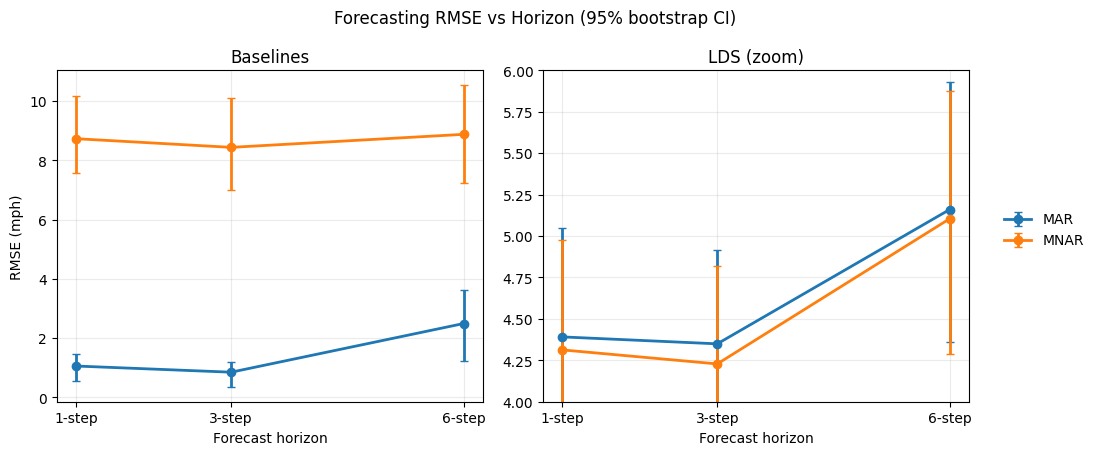

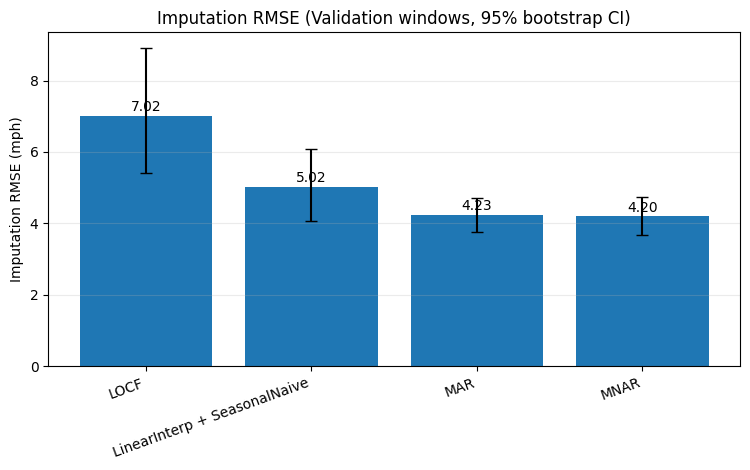

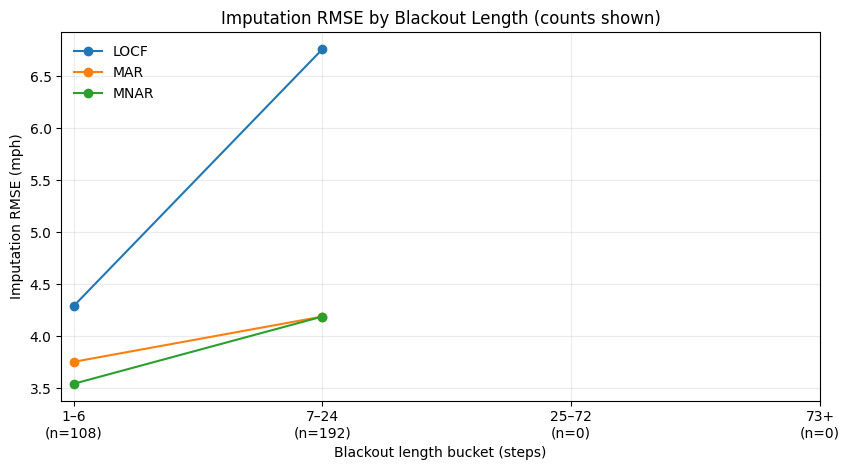

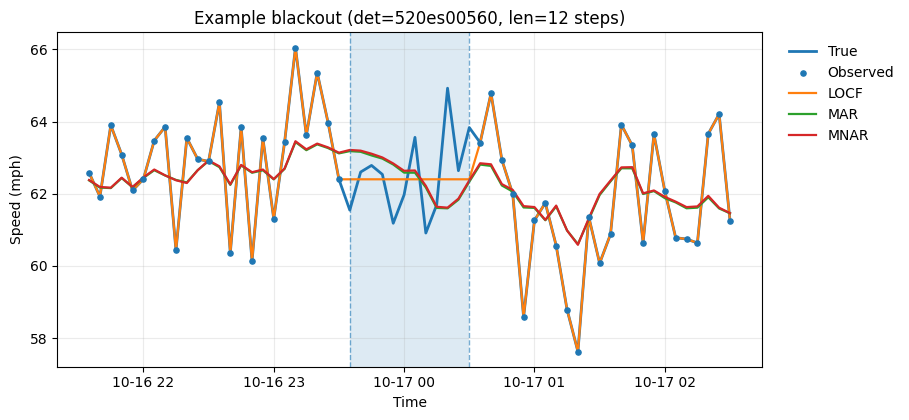

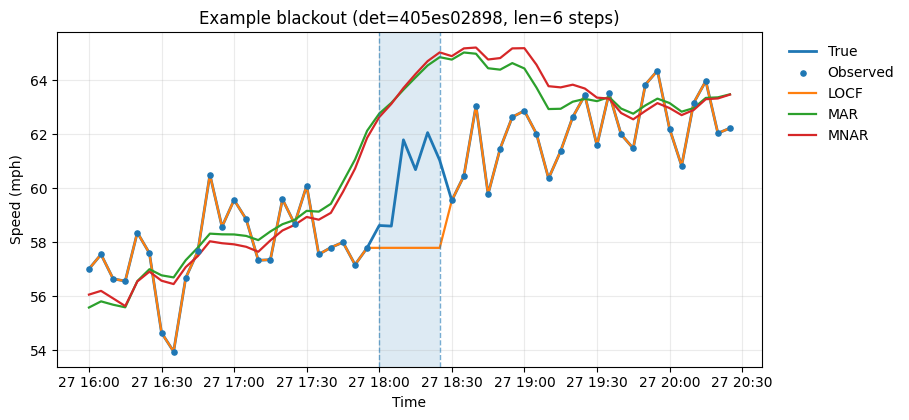

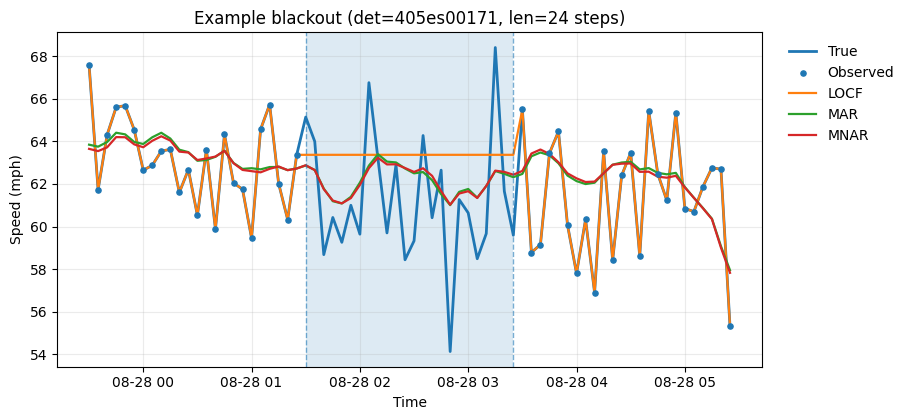

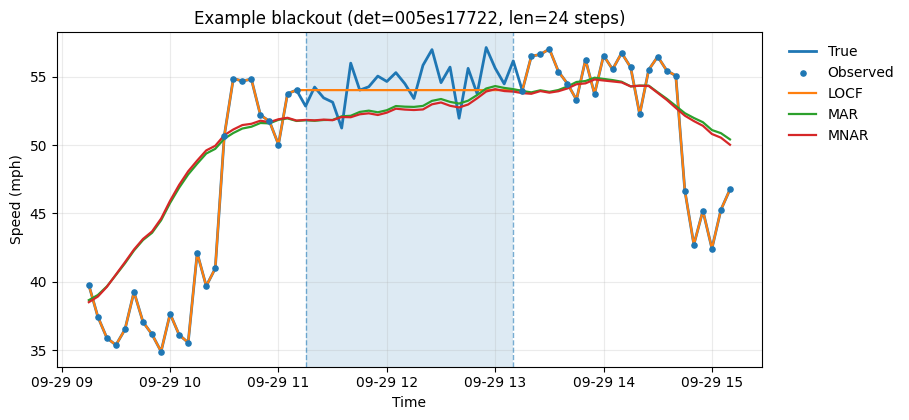


Saved figures to: c:\Users\Dell\Downloads\Modeling-Information-Blackouts-in-MNAR-Time-Series-main (2) (1)\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\figures


In [64]:
# ============================================================
# 5) Publication plots (paper-ready, saved to ./figures)
# ============================================================

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def _savefig(name: str):
    for ext in ["png", "pdf"]:
        plt.savefig(os.path.join(FIG_DIR, f"{name}.{ext}"),
                    dpi=300, bbox_inches="tight")

# ------------------------------
# Bootstrap CI helpers
# ------------------------------
def _bootstrap_ci(values, B=500, seed=0, agg_fn=np.mean, alpha=0.05):
    """
    Nonparametric bootstrap CI for a scalar statistic agg_fn(values).
    Returns: (center, lo, hi)
    """
    v = np.asarray(values, float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.nan, np.nan, np.nan
    rs = np.random.default_rng(seed)
    stats = np.empty(B, dtype=float)
    n = v.size
    for b in range(B):
        samp = v[rs.integers(0, n, size=n)]
        stats[b] = float(agg_fn(samp))
    center = float(agg_fn(v))
    lo = float(np.quantile(stats, alpha / 2))
    hi = float(np.quantile(stats, 1 - alpha / 2))
    return center, lo, hi

def _bootstrap_rmse_from_se(se_list, B=500, seed=0, alpha=0.05):
    """
    Bootstrap RMSE from a list of squared errors.
    Returns: (rmse_center, rmse_lo, rmse_hi)
    """
    se = np.asarray(se_list, float)
    se = se[np.isfinite(se)]
    if se.size == 0:
        return np.nan, np.nan, np.nan
    def _rmse(x): return float(np.sqrt(np.mean(x)))
    return _bootstrap_ci(se, B=B, seed=seed, agg_fn=_rmse, alpha=alpha)

def _bootstrap_weighted_rmse_from_mse(mse_list, weights, B=500, seed=0, alpha=0.05):
    """
    Bootstrap weighted RMSE given per-window MSE and per-window weights (e.g., len_steps).
    Resamples windows with replacement and recomputes weighted mean MSE -> RMSE.
    Returns: (rmse_center, rmse_lo, rmse_hi)
    """
    mse = np.asarray(mse_list, float)
    w = np.asarray(weights, float)
    mask = np.isfinite(mse) & np.isfinite(w) & (w > 0)
    mse = mse[mask]; w = w[mask]
    if mse.size == 0:
        return np.nan, np.nan, np.nan
    rs = np.random.default_rng(seed)
    n = mse.size
    stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = rs.integers(0, n, size=n)
        mm = mse[idx]; ww = w[idx]
        m_w = float(np.average(mm, weights=ww))
        stats[b] = float(np.sqrt(m_w))
    center = float(np.sqrt(np.average(mse, weights=w)))
    lo = float(np.quantile(stats, alpha / 2))
    hi = float(np.quantile(stats, 1 - alpha / 2))
    return center, lo, hi

def _collect_impute_window_mse(x_true, x_pred, meta, windows):
    """
    Returns:
      mse_list:  per-window MSE (over finite points)
      w_list:    per-window weights (len_steps)
    """
    mse_list, w_list = [], []
    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        y_true = x_true[s:e+1, d]
        y_pred = x_pred[s:e+1, d]
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue
        mse = sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask])
        mse_list.append(float(mse))
        w_list.append(int(w["len_steps"]))
    return mse_list, w_list

def _collect_forecast_window_se_model(model, mu_filt, Sigma_filt, x_true, meta, windows):
    """
    Returns dict horizon->list of squared errors for model forecasts.
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yhat_vec, _ = model.k_step_forecast(mu_filt, Sigma_filt, end_idx, k=h)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

def _collect_forecast_window_se_baseline(forecast_fn, x_true, x_masked, meta, windows):
    """
    Returns dict horizon->list of squared errors for baseline forecasts.
    forecast_fn(x_masked, target_idx, detector_idx) -> scalar
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yp = float(forecast_fn(x_masked, target_idx, d))
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

        
 # ---------------- Baselines: Linear interp + Seasonal naive ----------------
metrics_lin_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=linear_interp_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="LinearInterp (impute) + SeasonalNaive (forecast)",
)

# ============================================================
# A) Metrics summary table
# ============================================================
metrics_rows = [
    ("LOCF", baseline_locf_metrics),
    ("LinearInterp + SeasonalNaive", metrics_lin_season),
    ("MAR", metrics_mar),
    ("MNAR", metrics_mnar),
]

metrics_df = pd.DataFrame([
    {
        "method": name,
        "impute_rmse": md["impute_rmse"],
        "forecast_rmse_1": md["forecast_rmse_1"],
        "forecast_rmse_3": md["forecast_rmse_3"],
        "forecast_rmse_6": md["forecast_rmse_6"],
    }
    for name, md in metrics_rows
])

metrics_df.to_csv(os.path.join(FIG_DIR, "metrics_summary.csv"), index=False)
display(metrics_df)

# ============================================================
# B) Forecast RMSE vs horizon (two panels + 95% bootstrap CI)
# ============================================================
horizons = np.array([1, 3, 6])

# build SE lists for CI (same eval windows you used)
forecast_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

# Baselines: LOCF + SeasonalNaive
se_locf = _collect_forecast_window_se_baseline(
    forecast_fn=lambda xm, tidx, d: locf_forecast_baseline(xm, tidx, d),
    x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
)
se_season = _collect_forecast_window_se_baseline(
    forecast_fn=seasonal_naive_forecast_baseline,
    x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
)

# LDS models: MAR + MNAR
se_mar = _collect_forecast_window_se_model(
    model_mar, mu_filt_mar, Sigma_filt_mar, x_t, meta, forecast_windows_val
)
se_mnar = _collect_forecast_window_se_model(
    model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val
)

def _rmse_ci_curve(se_dict, seed=0, B=500):
    rmse = []
    lo = []
    hi = []
    for h in horizons:
        c, l, u = _bootstrap_rmse_from_se(se_dict[int(h)], B=B, seed=seed + int(h))
        rmse.append(c); lo.append(l); hi.append(u)
    rmse = np.asarray(rmse, float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    yerr = np.vstack([rmse - lo, hi - rmse])
    return rmse, yerr

base_curves = [
    ("LOCF", se_locf),
    ("SeasonalNaive", se_season),
]
lds_curves = [
    ("MAR", se_mar),
    ("MNAR", se_mnar),
]

fig, axes = plt.subplots(1, 2, figsize=(10.8, 4.6), sharex=True)

# Panel 1: baselines
ax = axes[0]
for name, se_dict in base_curves:
    y, yerr = _rmse_ci_curve(se_dict, seed=42, B=500)
    ax.errorbar(horizons, y, yerr=yerr, marker="o", linewidth=2, capsize=3, label=name)
ax.set_xticks(horizons, [f"{h}-step" for h in horizons])
ax.set_xlabel("Forecast horizon")
ax.set_ylabel("RMSE (mph)")
ax.set_title("Baselines")
ax.grid(True, alpha=0.25)

# Panel 2: LDS (zoomed y-lims to avoid baseline domination)
ax = axes[1]
for name, se_dict in lds_curves:
    y, yerr = _rmse_ci_curve(se_dict, seed=42, B=500)
    ax.errorbar(horizons, y, yerr=yerr, marker="o", linewidth=2, capsize=3, label=name)
ax.set_xticks(horizons, [f"{h}-step" for h in horizons])
ax.set_xlabel("Forecast horizon")
ax.set_title("LDS (zoom)")
ax.grid(True, alpha=0.25)
ax.set_ylim(4.0, 6.0)  # adjust if needed

# Legend outside to avoid overlap
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", frameon=False, bbox_to_anchor=(1.02, 0.5))
fig.suptitle("Forecasting RMSE vs Horizon (95% bootstrap CI)")
plt.tight_layout(rect=[0, 0, 0.92, 1])
_savefig("forecast_rmse_by_horizon_panels_ci")
plt.show()

# ============================================================
# C) Imputation RMSE bar plot (value labels + 95% bootstrap CI)
# ============================================================
def fill_impute_predictions(x_t_masked, windows, meta, impute_fn):
    x_pred = x_t_masked.copy().astype(float)
    seen = set()
    for w in windows:
        key = (w["blackout_start"], w["blackout_end"], w["detector_id"])
        if key in seen:
            continue
        seen.add(key)
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        x_pred[s:e+1, d] = impute_fn(x_t_masked, s, e, d)
    return x_pred

order = ["LOCF", "LinearInterp + SeasonalNaive", "MAR", "MNAR"]

# Create full imputation predictions used for per-window MSE collection
# (LOCF already built; MAR/MNAR recon built; linear interp uses fill helper)
recon_mar_full, _  = model_mar.reconstruct_from_smoother(mu_smooth_mar,  Sigma_smooth_mar)
recon_mnar_full, _ = model_mnar.reconstruct_from_smoother(mu_smooth_mnar, Sigma_smooth_mnar)

x_locf_full = fill_impute_predictions(
    x_t_train, impute_evaluation_windows_val, meta, locf_impute_baseline
)
x_lin_full = fill_impute_predictions(
    x_t_train, impute_evaluation_windows_val, meta, linear_interp_impute_baseline
)

impute_pred_map = {
    "LOCF": x_locf_full,
    "LinearInterp + SeasonalNaive": x_lin_full,
    "MAR": recon_mar_full,
    "MNAR": recon_mnar_full,
}

impute_vals = []
impute_yerr = []
for i, name in enumerate(order):
    mse_list, w_list = _collect_impute_window_mse(x_t, impute_pred_map[name], meta, impute_evaluation_windows_val)
    c, lo, hi = _bootstrap_weighted_rmse_from_mse(mse_list, w_list, B=500, seed=42 + i)
    impute_vals.append(c)
    impute_yerr.append([c - lo, hi - c])
impute_vals = np.asarray(impute_vals, float)
impute_yerr = np.asarray(impute_yerr, float).T  # shape (2, n_bars)

plt.figure(figsize=(7.6, 4.8))
bars = plt.bar(order, impute_vals, yerr=impute_yerr, capsize=4)
plt.ylabel("Imputation RMSE (mph)")
plt.title("Imputation RMSE (Validation windows, 95% bootstrap CI)")
plt.xticks(rotation=20, ha="right")
plt.grid(True, axis="y", alpha=0.25)

# Value labels on bars
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.05, f"{h:.2f}",
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
_savefig("impute_rmse_methods_ci_labels")
plt.show()

# ============================================================
# D) Imputation RMSE by blackout length bucket
#    (requires eval_impute_rmse_by_length helper)
# ============================================================
# Full reconstructions

(rmse_len_locf, n_len_locf) = eval_impute_rmse_by_length(x_t, x_locf_full, meta, impute_evaluation_windows_val)
(rmse_len_mar,  n_len_mar)  = eval_impute_rmse_by_length(x_t, recon_mar_full, meta, impute_evaluation_windows_val)
(rmse_len_mnar, n_len_mnar) = eval_impute_rmse_by_length(x_t, recon_mnar_full, meta, impute_evaluation_windows_val)

bucket_keys = ["1–6", "7–24", "25–72", "73+"]
xk = np.arange(len(bucket_keys))

# show counts (use MAR counts; should match across methods if windows identical)
bucket_labels = [f"{k}\n(n={n_len_mar.get(k,0)})" for k in bucket_keys]

plt.figure(figsize=(8.6, 4.8))
plt.plot(xk, [rmse_len_locf[k] for k in bucket_keys], marker="o", label="LOCF")
plt.plot(xk, [rmse_len_mar[k]  for k in bucket_keys], marker="o", label="MAR")
plt.plot(xk, [rmse_len_mnar[k] for k in bucket_keys], marker="o", label="MNAR")

# If buckets are empty, RMSE is NaN -> line breaks naturally; labels still show n=0
plt.xticks(xk, bucket_labels, rotation=0, ha="center")
plt.xlabel("Blackout length bucket (steps)")
plt.ylabel("Imputation RMSE (mph)")
plt.title("Imputation RMSE by Blackout Length (counts shown)")
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
_savefig("impute_rmse_by_length_bucket_counts")
plt.show()

# ============================================================
# E) Qualitative example windows
# ============================================================
def plot_example_windows(n_examples=4, seed=42):
    rs = np.random.default_rng(seed)
    picks = rs.choice(len(impute_evaluation_windows_val),
                      size=min(n_examples, len(impute_evaluation_windows_val)),
                      replace=False)
    for j, idx in enumerate(picks, 1):
        w = impute_evaluation_windows_val[int(idx)]
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        pad = 24
        a = max(0, s - pad)
        b = min(x_t.shape[0], e + pad + 1)

        plt.figure(figsize=(9.2, 4.3))

        # True (full) series for reference
        plt.plot(meta["timestamps"][a:b], x_t[a:b, d], label="True", linewidth=2)

        # Observed markers from the *masked* panel (shows what's actually available)
        obs_mask_seg = np.isfinite(x_t_train[a:b, d])
        plt.scatter(
            meta["timestamps"][a:b][obs_mask_seg],
            x_t_train[a:b, d][obs_mask_seg],
            s=14,
            marker="o",
            label="Observed",
            zorder=3,
        )

        # Reconstructions / imputations
        plt.plot(meta["timestamps"][a:b], x_locf_full[a:b, d], label="LOCF", linewidth=1.6)
        plt.plot(meta["timestamps"][a:b], recon_mar_full[a:b, d], label="MAR", linewidth=1.6)
        plt.plot(meta["timestamps"][a:b], recon_mnar_full[a:b, d], label="MNAR", linewidth=1.6)

        # Blackout region + boundary markers
        plt.axvspan(meta["timestamps"][s], meta["timestamps"][e], alpha=0.15)
        plt.axvline(meta["timestamps"][s], linestyle="--", linewidth=1.0, alpha=0.6)
        plt.axvline(meta["timestamps"][e], linestyle="--", linewidth=1.0, alpha=0.6)
        plt.title(f"Example blackout (det={w['detector_id']}, len={w['len_steps']} steps)")
        plt.ylabel("Speed (mph)")
        plt.xlabel("Time")
        plt.grid(True, alpha=0.25)
        plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))
        plt.tight_layout()
        _savefig(f"example_window_{j}")
        plt.show()

plot_example_windows()
print(f"\nSaved figures to: {os.path.abspath(FIG_DIR)}")


In [65]:
# ---------------- Baselines: Linear interp + Seasonal naive ----------------
metrics_lin_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=linear_interp_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="LinearInterp (impute) + SeasonalNaive (forecast)",
)

metrics_spline_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=spline_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="Spline (impute, fallback->linear) + SeasonalNaive (forecast)",
)

def _delta(a, b, key):
    return a[key] - b[key]

print("\n=== Summary deltas (lower is better) ===")
print("Dynamics win  (LOCF -> MAR)  impute_RMSE:", _delta(metrics_mar, baseline_locf_metrics, "impute_rmse"))
print("MNAR refine   (MAR  -> MNAR) impute_RMSE:", _delta(metrics_mnar, metrics_mar, "impute_rmse"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE1:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_1"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE3:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_3"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE6:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_6"))


[LinearInterp (impute) + SeasonalNaive (forecast)] Imputation performance:
  MAE : 2.9420739691303317
  MSE : 25.244752289688442
  RMSE: 5.024415616734791

[LinearInterp (impute) + SeasonalNaive (forecast)] Forecasting performance:
-----------------------------------
1-step MAE : 5.726646155673933
1-step MSE : 76.28043634701925
1-step RMSE: 8.733867204567472

-----------------------------------
3-step MAE : 5.145514505931172
3-step MSE : 71.25954873847641
3-step RMSE: 8.441537107569712

-----------------------------------
6-step MAE : 5.175778166055944
6-step MSE : 78.87375223480866
6-step RMSE: 8.881089586014133

[Spline (impute, fallback->linear) + SeasonalNaive (forecast)] Imputation performance:
  MAE : 6.66391246551659
  MSE : 142.03638008209154
  RMSE: 11.917901664390907

[Spline (impute, fallback->linear) + SeasonalNaive (forecast)] Forecasting performance:
-----------------------------------
1-step MAE : 5.726646155673933
1-step MSE : 76.28043634701925
1-step RMSE: 8.733867204

In [66]:
# ============================================================
# 5) BRITS / GRU-D hook
# ============================================================
try:
    # ------------------------------------------------------------
    # GRU-D style imputer (torch-only baseline)
    # - Causal imputation (uses past only)
    # - Forecasting via free-run after blackout end (no peeking)
    # ------------------------------------------------------------
    class GRUDImputer(nn.Module):
        def __init__(self, D: int, hidden: int = 128):
            super().__init__()
            self.D = D
            self.hidden = hidden
            # Per-feature decay -> D outputs
            self.decay = nn.Linear(D, D)
            # Input uses [x_tilde, obs_mask]
            self.inp = nn.Linear(2 * D, hidden)
            self.cell = nn.GRUCell(hidden, hidden)
            self.out = nn.Linear(hidden, D)

        def forward(
            self,
            x_filled: torch.Tensor,   # (B,T,D) NaNs already replaced
            obs_mask: torch.Tensor,   # (B,T,D) 1 if observed else 0
            delta: torch.Tensor,      # (B,T,D) time since last obs (in steps)
            x_mean: torch.Tensor,     # (D,)
            h0: torch.Tensor | None = None,  # (B,H)
            last_x0: torch.Tensor | None = None,  # (B,D) initial last observed per feature
        ):
            B, T, D = x_filled.shape
            device = x_filled.device

            if h0 is None:
                h = torch.zeros(B, self.hidden, device=device)
            else:
                h = h0

            # last observed value per feature
            if last_x0 is None:
                last_x = x_mean[None, :].repeat(B, 1)  # (B,D)
            else:
                last_x = last_x0

            preds = []
            h_seq = []

            for t in range(T):
                x_t = x_filled[:, t, :]         # (B,D)
                m_t = obs_mask[:, t, :]         # (B,D)
                d_t = delta[:, t, :]            # (B,D)

                # gamma = exp(-relu(W d + b))  in (0,1]
                gamma = torch.exp(-torch.relu(self.decay(d_t)))

                # GRU-D input imputation
                x_hat = gamma * last_x + (1.0 - gamma) * x_mean[None, :]
                x_tilde = m_t * x_t + (1.0 - m_t) * x_hat

                # update last observed
                last_x = m_t * x_t + (1.0 - m_t) * last_x

                u = torch.tanh(self.inp(torch.cat([x_tilde, m_t], dim=-1)))  # (B,H)
                h = self.cell(u, h)                                          # (B,H)
                y = self.out(h)                                              # (B,D)

                preds.append(y)
                h_seq.append(h)

            preds = torch.stack(preds, dim=1)   # (B,T,D)
            h_seq = torch.stack(h_seq, dim=1)   # (B,T,H)
            return preds, h_seq


    def _compute_delta(obs_mask_np: np.ndarray) -> np.ndarray:
        """
        obs_mask_np: (T,D) with 1 if observed else 0
        returns delta in steps since last observation, (T,D)
        """
        T, D = obs_mask_np.shape
        delta = np.zeros((T, D), dtype=np.float32)
        last = np.zeros((D,), dtype=np.float32)
        for t in range(T):
            if t > 0:
                last += 1.0
            # where observed at time t -> reset to 0
            obs = obs_mask_np[t].astype(bool)
            last[obs] = 0.0
            delta[t] = last
        return delta


    # -----------------------------
    # Prepare tensors from your panel
    # -----------------------------
    # Expected existing vars in your notebook:
    #   x_t_train, m_t_train, x_t, m_t, meta
    # where m_t is 1=missing, 0=observed
    x_train = x_t_train.copy().astype(np.float32)
    obs_mask = ((m_t_train == 0) & np.isfinite(x_train)).astype(np.float32)  # (T,D) 1=observed
    delta = _compute_delta(obs_mask)                                         # (T,D)

    # Compute mean/std using observed values only
    x_train_nan0 = np.nan_to_num(x_train, nan=0.0)
    obs_cnt = obs_mask.sum(axis=0) + 1e-6
    x_mean = ((x_train_nan0 * obs_mask).sum(axis=0) / obs_cnt).astype(np.float32)
    x_var  = (((x_train_nan0 - x_mean[None, :]) ** 2) * obs_mask).sum(axis=0) / obs_cnt
    x_std  = np.sqrt(np.maximum(x_var, 1e-6)).astype(np.float32)

    # Normalize; for missing entries, fill with 0 (=mean after normalization)
    x_norm = (x_train_nan0 - x_mean[None, :]) / x_std[None, :]
    x_filled = (x_norm * obs_mask).astype(np.float32)  # missing -> 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    D = x_filled.shape[1]
    model_grud = GRUDImputer(D=D, hidden=128).to(device)
    opt = torch.optim.Adam(model_grud.parameters(), lr=1e-3)

    x_mean_t = torch.tensor(np.zeros_like(x_mean), device=device)  # mean in normalized space is 0

    # -----------------------------
    # Mini-batch training via random subsequences
    # -----------------------------
    T_total = x_filled.shape[0]
    seq_len = 288           # 1 day on 5-min grid
    batch_size = 16
    steps = 1500       

    rs = np.random.default_rng(0)

    def make_batch():
        starts = rs.integers(0, max(1, T_total - seq_len - 1), size=batch_size)
        xb = np.stack([x_filled[s:s+seq_len] for s in starts], axis=0)     # (B,L,D)
        mb = np.stack([obs_mask[s:s+seq_len] for s in starts], axis=0)     # (B,L,D)
        db = np.stack([delta[s:s+seq_len] for s in starts], axis=0)        # (B,L,D)
        return xb, mb, db

    model_grud.train()
    for step in range(1, steps + 1):
        xb, mb, db = make_batch()
        xb_t = torch.from_numpy(xb).to(device)
        mb_t = torch.from_numpy(mb).to(device)
        db_t = torch.from_numpy(db).to(device)

        pred, _ = model_grud(xb_t, mb_t, db_t, x_mean_t)

        # loss only where observed (mb_t == 1)
        diff2 = (pred - xb_t) ** 2
        loss = (diff2 * mb_t).sum() / (mb_t.sum() + 1e-6)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_grud.parameters(), 1.0)
        opt.step()

        if step % 50 == 0:
            print(f"[GRU-D] step {step:4d}/{steps}  loss={float(loss):.5f}")

    # -----------------------------
    # One full forward pass to cache predictions + hidden states
    # -----------------------------
    model_grud.eval()
    with torch.no_grad():
        x_full = torch.from_numpy(x_filled[None, :, :]).to(device)     # (1,T,D) normalized
        m_full = torch.from_numpy(obs_mask[None, :, :]).to(device)     # (1,T,D)
        d_full = torch.from_numpy(delta[None, :, :]).to(device)        # (1,T,D)
        pred_full, h_full = model_grud(x_full, m_full, d_full, x_mean_t)
        pred_full = pred_full[0].cpu().numpy()                         # (T,D) normalized
        h_full = h_full[0].cpu().numpy()                               # (T,H)

    # De-normalize cached predictions back to mph for evaluation
    pred_full = (pred_full * x_std[None, :]) + x_mean[None, :]
    
    # Cache last observed value per feature at each timestep (for proper free-run)
    last_x_hist = np.zeros_like(x_train_nan0, dtype=np.float32)  # (T,D) in mph
    last = x_mean.copy()  # mph
    for t in range(x_filled.shape[0]):
        if t == 0:
            last = x_mean.copy()
        else:
            # update last where observed at time t
            obs = obs_mask[t].astype(bool)
            last[obs] = x_train_nan0[t, obs]  # mph
        last_x_hist[t] = last

    # -----------------------------
    # Forecast helper: free-run k steps after end_idx
    # -----------------------------
    def grud_forecast_k(end_idx: int, k: int) -> np.ndarray:
        """
        Returns predicted x at time end_idx + k, without using ground truth
        beyond end_idx (free-run with missing masks).
        """
        model_grud.eval()
        with torch.no_grad():
            # start hidden at end_idx
            h0 = torch.tensor(h_full[end_idx][None, :], device=device)  # (1,H)

            # Convert last observed mph -> normalized for GRU-D state init
            last_x0_mph = last_x_hist[end_idx][None, :]
            last_x0_norm = (last_x0_mph - x_mean[None, :]) / x_std[None, :]
            last_x0 = torch.tensor(last_x0_norm, device=device, dtype=torch.float32)  # (1,D)

            # build a tiny rollout of length k, with "all missing" inputs
            # delta should start from per-feature delta at end_idx and then increase
            xb = torch.zeros(1, k, D, device=device)  # normalized zeros (=mean)
            mb = torch.zeros(1, k, D, device=device)   # all missing
            delta0 = torch.tensor(delta[end_idx], device=device, dtype=torch.float32)  # (D,)
            step_vec = torch.arange(1, k + 1, device=device, dtype=torch.float32).view(k, 1)  # (k,1)
            db = (delta0.view(1, D) + step_vec).view(1, k, D)  # (1,k,D)

            pred_k, _ = model_grud(xb, mb, db, x_mean_t, h0=h0, last_x0=last_x0)
            y_norm = pred_k[0, -1].cpu().numpy()  # (D,) normalized
            return (y_norm * x_std) + x_mean       # (D,) mph

    # -----------------------------
    # Evaluate on the SAME windows using your existing evaluator
    # -----------------------------
    def grud_impute_fn(x_t_masked_unused, start_idx, end_idx, detector_idx):
        # causal predictions from pred_full on the masked training panel
        return pred_full[start_idx:end_idx+1, detector_idx].astype(float)

    # Better: custom forecast evaluation that knows end_idx + horizon (no leakage)
    def evaluate_grud_forecast_only(label="GRU-D (free-run forecast)"):
        y1t, y1p, y3t, y3p, y6t, y6p = [], [], [], [], [], []
        forecast_windows = (
            forecast_1_evaluation_windows_val
            + forecast_3_evaluation_windows_val
            + forecast_6_evaluation_windows_val
        )
        for w in forecast_windows:
            end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
            d = np.where(meta["detectors"] == w["detector_id"])[0][0]
            h = int(w["horizon_steps"])
            target_idx = end_idx + h
            if target_idx >= x_t.shape[0]:
                continue
            yt = float(x_t[target_idx, d])
            if not np.isfinite(yt):
                continue
            yp = float(grud_forecast_k(end_idx=end_idx, k=h)[d])
            if not np.isfinite(yp):
                continue
            if h == 1:
                y1t.append(yt); y1p.append(yp)
            elif h == 3:
                y3t.append(yt); y3p.append(yp)
            elif h == 6:
                y6t.append(yt); y6p.append(yp)

        import sklearn.metrics
        def _pack(y_pred, y_true, h):
            mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
            mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
            rmse = float(np.sqrt(mse))
            print(f"{h}-step MAE : {mae}")
            print(f"{h}-step MSE : {mse}")
            print(f"{h}-step RMSE: {rmse}")

        print(f"\n[{label}] Forecasting performance (free-run):")
        print("-----------------------------------")
        _pack(y1p, y1t, 1)
        print("\n-----------------------------------")
        _pack(y3p, y3t, 3)
        print("\n-----------------------------------")
        _pack(y6p, y6t, 6)


    # Use your baseline evaluator for imputation (forecasting handled by custom function above)
    metrics_grud_impute = evaluate_impute_forecast_baseline(
        x_t_true=x_t,
        x_t_masked=x_t_train,
        meta=meta,
        impute_fn=grud_impute_fn,
        forecast_fn=seasonal_naive_forecast_baseline,  # keep a sane baseline here
        label="GRU-D (impute via torch) + SeasonalNaive (forecast)",
    )
    evaluate_grud_forecast_only(label="GRU-D (free-run forecast)")

    print("\n[GRU-D] Done.")
except Exception:
    print("\n[Optional] torch not available; skipping BRITS/GRU-D baseline hook.")

[GRU-D] step   50/1500  loss=0.29229
[GRU-D] step  100/1500  loss=0.22483
[GRU-D] step  150/1500  loss=0.22417
[GRU-D] step  200/1500  loss=0.17645
[GRU-D] step  250/1500  loss=0.15063
[GRU-D] step  300/1500  loss=0.12224
[GRU-D] step  350/1500  loss=0.11840
[GRU-D] step  400/1500  loss=0.13568
[GRU-D] step  450/1500  loss=0.10361
[GRU-D] step  500/1500  loss=0.08436
[GRU-D] step  550/1500  loss=0.07633
[GRU-D] step  600/1500  loss=0.07683
[GRU-D] step  650/1500  loss=0.06345
[GRU-D] step  700/1500  loss=0.06247
[GRU-D] step  750/1500  loss=0.06473
[GRU-D] step  800/1500  loss=0.05059
[GRU-D] step  850/1500  loss=0.05214
[GRU-D] step  900/1500  loss=0.05303
[GRU-D] step  950/1500  loss=0.04045
[GRU-D] step 1000/1500  loss=0.04374
[GRU-D] step 1050/1500  loss=0.04198
[GRU-D] step 1100/1500  loss=0.04473
[GRU-D] step 1150/1500  loss=0.03315
[GRU-D] step 1200/1500  loss=0.04192
[GRU-D] step 1250/1500  loss=0.04312
[GRU-D] step 1300/1500  loss=0.03716
[GRU-D] step 1350/1500  loss=0.03878
[

In [67]:
import sklearn.metrics

def evaluate_grud_impute_forecast(
    x_t_true,
    x_t_masked,          # (T,D) masked panel used to compute obs_mask/delta etc.
    meta,
    impute_windows,
    forecast_windows,
    pred_full,           # (T,D) GRU-D one-pass causal preds on masked panel
    grud_forecast_k_fn,  # function: (end_idx, k) -> (D,)
    label="GRU-D",
):
    # ---------------- Imputation ----------------
    impute_mae_list = []
    impute_mse_list = []

    for w in impute_windows:
        if w["test_type"] != "impute":
            continue
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        y_true = x_t_true[s:e+1, d].astype(float)
        y_pred = pred_full[s:e+1, d].astype(float)  # causal preds from masked pass

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_true[mask], y_pred[mask])
        mse = sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask])

        impute_mae_list.append([float(mae), int(w["len_steps"])])
        impute_mse_list.append([float(mse), int(w["len_steps"])])

    final_impute_mae = float(np.average([a for a,_ in impute_mae_list], weights=[w for _,w in impute_mae_list]))
    final_impute_mse = float(np.average([a for a,_ in impute_mse_list], weights=[w for _,w in impute_mse_list]))
    final_impute_rmse = float(np.sqrt(final_impute_mse))

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_impute_mae)
    print("  MSE :", final_impute_mse)
    print("  RMSE:", final_impute_rmse)

    # ---------------- Forecasting (free-run) ----------------
    y1t, y1p, y3t, y3p, y6t, y6p = [], [], [], [], [], []
    forecast_se = {1: [], 3: [], 6: []}

    for w in forecast_windows:
        if w["test_type"] != "forecast":
            continue

        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_t_true.shape[0]:
            continue

        yt = float(x_t_true[target_idx, d])
        if not np.isfinite(yt):
            continue

        yhat_vec = grud_forecast_k_fn(end_idx=end_idx, k=h)  # (D,)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue

        # Store squared error for bootstrap CI
        if h in forecast_se:
            forecast_se[h].append(float((yp - yt) ** 2))

        if h == 1:
            y1t.append(yt); y1p.append(yp)
        elif h == 3:
            y3t.append(yt); y3p.append(yp)
        elif h == 6:
            y6t.append(yt); y6p.append(yp)

    def _pack(y_pred, y_true, h):
        mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
        mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
        rmse = float(np.sqrt(mse))
        print(f"{h}-step MAE :", mae)
        print(f"{h}-step MSE :", mse)
        print(f"{h}-step RMSE:", rmse)
        return float(mae), float(mse), float(rmse)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    mae1, mse1, rmse1 = _pack(y1p, y1t, 1)
    print("\n-----------------------------------")
    mae3, mse3, rmse3 = _pack(y3p, y3t, 3)
    print("\n-----------------------------------")
    mae6, mse6, rmse6 = _pack(y6p, y6t, 6)

    return {
        "impute_mae": final_impute_mae,
        "impute_mse": final_impute_mse,
        "impute_rmse": final_impute_rmse,
        "forecast_mae_1": mae1, "forecast_mse_1": mse1, "forecast_rmse_1": rmse1,
        "forecast_mae_3": mae3, "forecast_mse_3": mse3, "forecast_rmse_3": rmse3,
        "forecast_mae_6": mae6, "forecast_mse_6": mse6, "forecast_rmse_6": rmse6,
        "forecast_se": forecast_se,
    }

_grud_cache = {}
def grud_forecast_k_cached(end_idx: int, k: int) -> np.ndarray:
    """
    Cache GRU-D free-run forecasts per (end_idx, horizon) so CI/plots don't re-rollout repeatedly.
    Requires your existing grud_forecast_k(end_idx=..., k=...) -> (D,) to be defined elsewhere.
    """
    key = (int(end_idx), int(k))
    if key not in _grud_cache:
        _grud_cache[key] = grud_forecast_k(end_idx=end_idx, k=k)
    return _grud_cache[key]

def _collect_forecast_window_se_locf(x_true, x_masked, meta, windows):
    """
    LOCF forecast SE collector (NO leakage).
    IMPORTANT: locf_forecast_baseline(x_t_masked, end_idx, detector_idx) expects end_idx,
    not target_idx. Passing target_idx leaks because x_t_train[target_idx] isn't masked.
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue

        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue

        # IMPORTANT: LOCF uses end_idx (end of blackout), not target_idx
        yp = float(locf_forecast_baseline(x_masked, end_idx, d))
        if not np.isfinite(yp):
            continue

        out[h].append(float((yp - float(yt)) ** 2))
    return out

def _collect_forecast_window_se_grud(grud_forecast_k_fn, x_true, meta, windows):
    """
    GRU-D forecast SE collector using a cached free-run forecaster.
      grud_forecast_k_fn(end_idx, k) -> (D,) vector of forecasts at horizon k
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yhat_vec = grud_forecast_k_fn(end_idx=end_idx, k=h)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

In [68]:
# ============================================================
# 6) Robustness: bootstrap CI table (same fitted models)
# ============================================================
# (i) Bootstrap metrics directly from per-window error lists
def summarize_with_ci():
    # Imputation weighted RMSE CI
    rows = []
    for name in order:
        mse_list, w_list = _collect_impute_window_mse(x_t, impute_pred_map[name], meta, impute_evaluation_windows_val)
        c, lo, hi = _bootstrap_weighted_rmse_from_mse(mse_list, w_list, B=1000, seed=123)
        row = {"method": name, "impute_rmse": c, "impute_rmse_ci_lo": lo, "impute_rmse_ci_hi": hi}
        rows.append(row)

    # Forecast RMSE CI (1/3/6)
    forecast_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )
    se_locf_local = _collect_forecast_window_se_locf(
        x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
    )
    se_season_local = _collect_forecast_window_se_baseline(
        forecast_fn=seasonal_naive_forecast_baseline,
        x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
    )
    se_mar_local = _collect_forecast_window_se_model(
        model_mar, mu_filt_mar, Sigma_filt_mar, x_t, meta, forecast_windows_val
    )
    se_mnar_local = _collect_forecast_window_se_model(
        model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val
    )
    se_map = {
        "LOCF": se_locf_local,
        "SeasonalNaive": se_season_local,
        "MAR": se_mar_local,
        "MNAR": se_mnar_local,
        "GRU-D": se_grud if "se_grud" in globals() else {1: [], 3: [], 6: []},
    }

    for h in [1, 3, 6]:
        if len(se_locf_local[h]) > 0:
            print(f"[sanity] LOCF horizon={h} RMSE_from_SE={np.sqrt(np.mean(se_locf_local[h])):.3f}  (n={len(se_locf_local[h])})")
 
    for r in rows:
        name = r["method"]
        se_dict = se_map["SeasonalNaive"] if name == "LinearInterp + SeasonalNaive" else se_map[name]
        for h in [1, 3, 6]:
            c, lo, hi = _bootstrap_rmse_from_se(se_dict[h], B=1000, seed=1000 + 97*h + hash(name) % 10_000)
            r[f"forecast_rmse_{h}"] = c
            r[f"forecast_rmse_{h}_ci_lo"] = lo
            r[f"forecast_rmse_{h}_ci_hi"] = hi

    df = pd.DataFrame(rows)
    display(df)
    df.to_csv(os.path.join(FIG_DIR, "metrics_with_bootstrap_ci.csv"), index=False)
    print("Saved:", os.path.join(FIG_DIR, "metrics_with_bootstrap_ci.csv"))

forecast_evaluation_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

metrics_grud = evaluate_grud_impute_forecast(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_windows=impute_evaluation_windows_val,
    forecast_windows=forecast_evaluation_windows_val,
    pred_full=pred_full,
    grud_forecast_k_fn=grud_forecast_k_cached,
    label="GRU-D",
)
se_grud = metrics_grud["forecast_se"]

summarize_with_ci()


[GRU-D] Imputation performance:
  MAE : 3.2305558263713223
  MSE : 23.868383227663347
  RMSE: 4.885527937456027

[GRU-D] Forecasting performance:
-----------------------------------
1-step MAE : 3.974064200489263
1-step MSE : 35.75581334996504
1-step RMSE: 5.979616488535451

-----------------------------------
3-step MAE : 4.751462736938112
3-step MSE : 50.29724815315961
3-step RMSE: 7.092055284130236

-----------------------------------
6-step MAE : 5.607929564739264
6-step MSE : 71.57188777446203
6-step RMSE: 8.460017007929832
[sanity] LOCF horizon=1 RMSE_from_SE=7.860  (n=300)
[sanity] LOCF horizon=3 RMSE_from_SE=8.465  (n=300)
[sanity] LOCF horizon=6 RMSE_from_SE=8.942  (n=300)


,method,impute_rmse,impute_rmse_ci_lo,impute_rmse_ci_hi,forecast_rmse_1,forecast_rmse_1_ci_lo,forecast_rmse_1_ci_hi,forecast_rmse_3,forecast_rmse_3_ci_lo,forecast_rmse_3_ci_hi,forecast_rmse_6,forecast_rmse_6_ci_lo,forecast_rmse_6_ci_hi
0,LOCF,7.021057,5.274564,8.979957,7.860342,6.224674,9.606468,8.465183,6.584359,10.491009,8.941693,6.976088,10.879578
1,LinearInterp + SeasonalNaive,5.024416,4.058139,6.052568,8.733867,7.406915,10.067641,8.441537,6.832504,10.058236,8.881090,7.217547,10.610704
2,MAR,4.228815,3.761474,4.714108,4.391176,3.814267,5.071481,4.349354,3.769646,5.026279,5.159922,4.358516,5.943814
3,MNAR,4.195356,3.697326,4.733781,4.312736,3.748007,4.961545,4.228140,3.620566,4.858031,5.104356,4.321551,5.886977


Saved: figures\metrics_with_bootstrap_ci.csv


In [69]:

# ==========================================================
# 7) Multi-seed robustness (re-train 3–5 seeds)
# ==========================================================

SEEDS = [0, 1, 2, 3, 4]
seed_results = []
for s in SEEDS:
    # (A) re-sample windows with different seed (keeps month stratification)
    random.seed(s); np.random.seed(s)
    impute_evaluation_windows_val_s = stratified_month_sampling(impute_windows_pool, n_per_month=25, ts_key="blackout_start")
    val_ids_ordered_s = [w["window_id"] for w in impute_evaluation_windows_val_s]
    forecast_1_val_s = [forecast_1_by_id[wid] for wid in val_ids_ordered_s]
    forecast_3_val_s = [forecast_3_by_id[wid] for wid in val_ids_ordered_s]
    forecast_6_val_s = [forecast_6_by_id[wid] for wid in val_ids_ordered_s]
    evaluation_windows_val_s = forecast_1_val_s + forecast_3_val_s + forecast_6_val_s + impute_evaluation_windows_val_s

    # (B) re-mask train panel for this seed
    x_t_train_s, m_t_train_s, a_t_train_s = mask_evaluation_windows(x_t, m_t, evaluation_windows_val_s, meta)

    # (C) re-train MAR then MNAR (you can reduce num_iters for speed)
    mar_params_s = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=s)
    model_mar_s = mnar_blackout_lds.MNARBlackoutLDS(mar_params_s, use_missingness_obs=False)
    model_mar_s.em_train(x_t_train_s, m_t_train_s, num_iters=10, update_phi=False,
                         phi_steps=0, phi_lr=0.0, verbose=False, convergence_tol=1e-3,
                         use_missingness_obs=False)

    mnar_params_s = copy.deepcopy(model_mar_s.params)
    if hasattr(mnar_params_s, "phi") and (mnar_params_s.phi is not None): mnar_params_s.phi[:] = 0.0
    if hasattr(mnar_params_s, "phi_time") and (mnar_params_s.phi_time is not None) and (mnar_params_s.phi_time.size > 0): mnar_params_s.phi_time[:] = 0.0
    if hasattr(mnar_params_s, "phi_det") and (mnar_params_s.phi_det is not None) and (mnar_params_s.phi_det.size > 0): mnar_params_s.phi_det[:] = 0.0
    if hasattr(mnar_params_s, "bias_m") and (mnar_params_s.bias_m is not None): mnar_params_s.bias_m[:] = 0.0

    model_mnar_s = mnar_blackout_lds.MNARBlackoutLDS(mnar_params_s, use_missingness_obs=True, missingness_var_mode="moment")
    model_mnar_s.em_train(x_t_train_s, m_t_train_s, num_iters=10, update_phi=True, phi_steps=2, phi_lr=1e-4,
                          verbose=False, convergence_tol=1e-3, use_missingness_obs=True,
                          init_missingness_bias=True, init_phi_if_zero=True, init_phi_noise=1e-3, init_seed=s)

    # (D) Evaluate on THIS seed’s windows
    ekf_mar_s = model_mar_s.ekf_forward(x_t_train_s, m_t_train_s)
    sm_mar_s  = model_mar_s.rts_smoother(ekf_mar_s)

    ekf_mnar_s = model_mnar_s.ekf_forward(
        x_t_train_s, m_t_train_s,
        a_t=a_t_train_s,
        X_time=X_time,
        detector_features=detector_features,
    )
    sm_mnar_s  = model_mnar_s.rts_smoother(ekf_mnar_s)

    forecast_windows_s = forecast_1_val_s + forecast_3_val_s + forecast_6_val_s

    metrics_mar_s = evaluate_impute_forecast_model(
        model=model_mar_s,
        mu_smooth=sm_mar_s["mu_smooth"],
        Sigma_smooth=sm_mar_s["Sigma_smooth"],
        mu_filt=ekf_mar_s["mu_filt"],
        Sigma_filt=ekf_mar_s["Sigma_filt"],
        x_t=x_t,
        meta=meta,
        label=f"MAR seed={s}",
        impute_windows=impute_evaluation_windows_val_s,
        forecast_windows=forecast_windows_s,
    )

    metrics_mnar_s = evaluate_impute_forecast_model(
        model=model_mnar_s,
        mu_smooth=sm_mnar_s["mu_smooth"],
        Sigma_smooth=sm_mnar_s["Sigma_smooth"],
        mu_filt=ekf_mnar_s["mu_filt"],
        Sigma_filt=ekf_mnar_s["Sigma_filt"],
        x_t=x_t,
        meta=meta,
        label=f"MNAR seed={s}",
        impute_windows=impute_evaluation_windows_val_s,
        forecast_windows=forecast_windows_s,
    )

    seed_results.append({
        "seed": s,
        "MAR_impute_rmse": metrics_mar_s["impute_rmse"],
        "MNAR_impute_rmse": metrics_mnar_s["impute_rmse"],
        "MAR_fcast_rmse_1": metrics_mar_s["forecast_rmse_1"],
        "MNAR_fcast_rmse_1": metrics_mnar_s["forecast_rmse_1"],
        "MAR_fcast_rmse_3": metrics_mar_s["forecast_rmse_3"],
        "MNAR_fcast_rmse_3": metrics_mnar_s["forecast_rmse_3"],
        "MAR_fcast_rmse_6": metrics_mar_s["forecast_rmse_6"],
        "MNAR_fcast_rmse_6": metrics_mnar_s["forecast_rmse_6"],
    })
    
print("Multi-seed robustness skeleton ready.")

df = pd.DataFrame(seed_results)
print(df.describe().T[["mean","std","min","max"]])
print("\nDelta (MNAR - MAR) mean:")
for k in ["impute_rmse","fcast_rmse_1","fcast_rmse_3","fcast_rmse_6"]:
    print(k, (df[f"MNAR_{k}"] - df[f"MAR_{k}"]).mean())


[MAR seed=0] Imputation performance:
  MAE : 2.9236246004018556
  MSE : 19.399535806820026
  RMSE: 4.4044904139775385

[MAR seed=0] Forecasting performance:
-----------------------------------
1-step MAE : 3.192487120552901
1-step MSE : 21.732031306110336
1-step RMSE: 4.661762682302729

-----------------------------------
3-step MAE : 3.069976020556438
3-step MSE : 20.08668583266784
3-step RMSE: 4.481817246683296

-----------------------------------
6-step MAE : 3.068341146078558
6-step MSE : 19.453178221374728
6-step RMSE: 4.410575724480278

[MNAR seed=0] Imputation performance:
  MAE : 2.878459005987187
  MSE : 18.848388522724488
  RMSE: 4.341473082114467

[MNAR seed=0] Forecasting performance:
-----------------------------------
1-step MAE : 3.1681564193387164
1-step MSE : 21.24242415589535
1-step RMSE: 4.608950439730867

-----------------------------------
3-step MAE : 3.0516023094711233
3-step MSE : 19.964209222207906
3-step RMSE: 4.468132632566753

------------------------------

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import numpy as np

def build_nextstep_missingness_dataset_balanced(
    x_t_true, m_t_true, X_time, mu_smooth,
    sample_stride=12, max_pos=20_000, neg_per_pos=3, seed=0, ds_per_t=64,
):
    rs = np.random.default_rng(seed)
    T, D = x_t_true.shape
    pos, neg = [], []

    for t in range(0, T - 2, sample_stride):
        ds = rs.integers(0, D, size=min(ds_per_t, D))
        for d in ds:
            if not np.isfinite(x_t_true[t, d]):
                continue
            y = int(m_t_true[t + 1, d] > 0)
            if y != 1:
                continue
            feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]], axis=0)
            feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]], axis=0)
            pos.append((t, feat_obs, feat_lat, 1))
            if len(pos) >= max_pos:
                break
        if len(pos) >= max_pos:
            break

    if len(pos) == 0:
        raise RuntimeError("No positive (missing) examples found. Check m_t encoding or sampling.")

    max_neg = int(neg_per_pos * len(pos))
    pos_t0 = np.asarray([t for (t, *_rest) in pos], dtype=int)
    while len(neg) < max_neg:
        t = int(pos_t0[rs.integers(0, len(pos_t0))])
        d = int(rs.integers(0, D))
        if t >= T - 2:
            continue
        if not np.isfinite(x_t_true[t, d]):
            continue
        y = int(m_t_true[t + 1, d] > 0)
        if y != 0:
            continue
        feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]], axis=0)
        feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]], axis=0)
        neg.append((t, feat_obs, feat_lat, 0))

    data = pos + neg
    data.sort(key=lambda z: z[0])  # time-aware split
    Xobs = np.asarray([a for _, a, _, _ in data], float)
    Xlat = np.asarray([b for _, _, b, _ in data], float)
    y    = np.asarray([c for *_x, c in data], int)
    return Xobs, Xlat, y

# Build MNAR smoother if not already available
if "mu_smooth_mnar" not in globals():
    ekf_tmp = model_mnar.ekf_forward(x_t_train, m_t_train, a_t=a_t_train, X_time=X_time, detector_features=detector_features)
    sm_tmp = model_mnar.rts_smoother(ekf_tmp)
    mu_smooth_mnar = sm_tmp["mu_smooth"]

X2_obs, X2_lat, y2 = build_nextstep_missingness_dataset_balanced(
    x_t_true=x_t,
    m_t_true=m_t,
    X_time=X_time,
    mu_smooth=mu_smooth_mnar,   # <<< MNAR latent, not MAR latent
    sample_stride=12,
    max_pos=20_000,
    neg_per_pos=3,
    seed=0,
)

pos_rate = float(y2.mean())
print(f"[Test2 Balanced MNAR-latent] N={len(y2)}  pos_rate={pos_rate:.6f}")

n = len(y2)
split = int(0.7 * n)
Xobs_tr, Xobs_te = X2_obs[:split], X2_obs[split:]
Xlat_tr, Xlat_te = X2_lat[:split], X2_lat[split:]
y_tr, y_te       = y2[:split], y2[split:]

clf_obs = LogisticRegression(max_iter=4000, n_jobs=-1, class_weight="balanced").fit(Xobs_tr, y_tr)
clf_lat = LogisticRegression(max_iter=4000, n_jobs=-1, class_weight="balanced").fit(Xlat_tr, y_tr)

for name, clf, Xte in [("OBS", clf_obs, Xobs_te), ("LAT+state", clf_lat, Xlat_te)]:
    p = clf.predict_proba(Xte)[:, 1]
    print(f"[{name}] ROC-AUC:", roc_auc_score(y_te, p))
    print(f"[{name}] PR-AUC :", average_precision_score(y_te, p))
    print(f"[{name}] LogLoss:", log_loss(y_te, p))


[Test2 Balanced MNAR-latent] N=60  pos_rate=0.250000
[OBS] ROC-AUC: 0.5178571428571428
[OBS] PR-AUC : 0.31805555555555554
[OBS] LogLoss: 0.6674251493989044
[LAT+state] ROC-AUC: 0.6785714285714286
[LAT+state] PR-AUC : 0.49722222222222223
[LAT+state] LogLoss: 1.1403720963203567


In [71]:
import numpy as np

# z-scores (avoid scipy dependency)
Z_TABLE = {0.90: 1.6448536269514722, 0.95: 1.959963984540054}

def _diag_from_cov(cov):
    """
    Accepts:
      - (T,D,D) -> (T,D) diag
      - (T,D)   -> (T,D)
      - (D,D)   -> (D,)
      - (D,)    -> (D,)
    """
    cov = np.asarray(cov)
    if cov.ndim == 3:
        return np.diagonal(cov, axis1=1, axis2=2)
    if cov.ndim == 2:
        # could be (T,D) or (D,D)
        if cov.shape[0] == cov.shape[1]:
            return np.diagonal(cov, axis1=0, axis2=1)
        return cov
    if cov.ndim == 1:
        return cov
    raise ValueError(f"Unsupported cov shape: {cov.shape}")

def gaussian_nll(y, mu, var, eps=1e-6):
    var = np.maximum(var, eps)
    return 0.5 * (np.log(2*np.pi*var) + ((y-mu)**2)/var)

def _collect_impute_calib(model, mu_smooth, Sigma_smooth, x_true, meta, windows, level=0.90):
    z = Z_TABLE[level]
    nlls, cover, widths = [], [], []
    for w in windows:
        if w["test_type"] != "impute": 
            continue
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        mu_seg = mu_smooth[s:e+1]
        S_seg  = Sigma_smooth[s:e+1]
        xhat, xcov = model.reconstruct_from_smoother(mu_seg, S_seg)

        y = x_true[s:e+1, d].astype(float)
        m = xhat[:, d].astype(float)

        if xcov is None:
            continue
        v_all = _diag_from_cov(xcov)
        v = v_all[:, d].astype(float)

        mask = np.isfinite(y) & np.isfinite(m) & np.isfinite(v)
        if not mask.any():
            continue

        nll = gaussian_nll(y[mask], m[mask], v[mask])
        nlls.extend(list(nll))

        sd = np.sqrt(np.maximum(v[mask], 1e-6))
        lo = m[mask] - z*sd
        hi = m[mask] + z*sd
        cover.extend(list((y[mask] >= lo) & (y[mask] <= hi)))
        widths.extend(list(hi - lo))

    return {
        "nll_mean": float(np.mean(nlls)) if len(nlls) else np.nan,
        "coverage": float(np.mean(cover)) if len(cover) else np.nan,
        "width_mean": float(np.mean(widths)) if len(widths) else np.nan,
        "n_points": int(len(nlls)),
    }

def _collect_forecast_calib(model, mu_filt, Sigma_filt, x_true, meta, windows, level=0.90):
    z = Z_TABLE[level]
    nlls, cover, widths = [], [], []
    for w in windows:
        if w["test_type"] != "forecast":
            continue
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue

        y = float(x_true[target_idx, d])
        if not np.isfinite(y):
            continue

        mu_vec, cov = model.k_step_forecast(mu_filt, Sigma_filt, end_idx, k=h)
        mu = float(mu_vec[d])
        if cov is None:
            continue
        vdiag = _diag_from_cov(cov)
        var = float(vdiag[d]) if np.ndim(vdiag) else float(vdiag)

        if not (np.isfinite(mu) and np.isfinite(var)):
            continue

        nlls.append(float(gaussian_nll(y, mu, var)))
        sd = float(np.sqrt(max(var, 1e-6)))
        lo, hi = mu - z*sd, mu + z*sd
        cover.append(bool((y >= lo) and (y <= hi)))
        widths.append(float(hi - lo))

    return {
        "nll_mean": float(np.mean(nlls)) if len(nlls) else np.nan,
        "coverage": float(np.mean(cover)) if len(cover) else np.nan,
        "width_mean": float(np.mean(widths)) if len(widths) else np.nan,
        "n_points": int(len(nlls)),
    }

forecast_windows_val = forecast_1_evaluation_windows_val + forecast_3_evaluation_windows_val + forecast_6_evaluation_windows_val

for lvl in [0.90, 0.95]:
    print(f"\n=== Calibration @ {int(lvl*100)}% interval ===")
    mar_imp = _collect_impute_calib(model_mar, mu_smooth_mar, Sigma_smooth_mar, x_t, meta, impute_evaluation_windows_val, level=lvl)
    mar_for = _collect_forecast_calib(model_mar, mu_filt_mar, Sigma_filt_mar, x_t, meta, forecast_windows_val, level=lvl)
    mnar_imp = _collect_impute_calib(model_mnar, mu_smooth_mnar, Sigma_smooth_mnar, x_t, meta, impute_evaluation_windows_val, level=lvl)
    mnar_for = _collect_forecast_calib(model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val, level=lvl)

    print("[MAR]  impute:", mar_imp)
    print("[MAR]  fcast :", mar_for)
    print("[MNAR] impute:", mnar_imp)
    print("[MNAR] fcast :", mnar_for)



=== Calibration @ 90% interval ===
[MAR]  impute: {'nll_mean': nan, 'coverage': nan, 'width_mean': nan, 'n_points': 0}
[MAR]  fcast : {'nll_mean': 2.9360323295398914, 'coverage': 0.9011111111111111, 'width_mean': 14.461619767060743, 'n_points': 900}
[MNAR] impute: {'nll_mean': nan, 'coverage': nan, 'width_mean': nan, 'n_points': 0}
[MNAR] fcast : {'nll_mean': 2.9097761408950413, 'coverage': 0.9133333333333333, 'width_mean': 14.444084025903164, 'n_points': 900}

=== Calibration @ 95% interval ===
[MAR]  impute: {'nll_mean': nan, 'coverage': nan, 'width_mean': nan, 'n_points': 0}
[MAR]  fcast : {'nll_mean': 2.9360323295398914, 'coverage': 0.94, 'width_mean': 17.2320828048901, 'n_points': 900}
[MNAR] impute: {'nll_mean': nan, 'coverage': nan, 'width_mean': nan, 'n_points': 0}
[MNAR] fcast : {'nll_mean': 2.9097761408950413, 'coverage': 0.9411111111111111, 'width_mean': 17.211187680516773, 'n_points': 900}


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dell\App

,window_id,detector_id,detector_group,len_steps,tod,start_ts,rmse_LOCF,rmse_LinearInterp,rmse_MAR,rmse_MNAR
0,367,405es02808,type0,12,18–24,2015-03-29 20:05:00,1.059476,0.709311,0.714898,0.668233
1,77,005es16583,type1,24,12–18,2015-03-26 16:00:00,5.388875,4.738260,7.327140,5.549430
2,0,005es15036,type0,6,12–18,2015-03-01 13:15:00,0.910201,0.658704,4.802426,4.781450
3,398,520es00397,type4,24,12–18,2015-03-28 13:35:00,0.481939,0.461731,3.798900,4.062038
4,131,005es18066,type2,24,18–24,2015-03-13 20:25:00,2.151885,3.078238,1.597913,1.503854



=== Impute RMSE by length bucket: MAR ===


C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\2248195734.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_cols)[metric_col].agg(["mean","median","count"]).reset_index()


,len_bucket,mean,median,count
0,1–6,3.092473,2.460845,108
1,7–24,3.357354,2.576282,192
2,25–72,NaN,NaN,0
3,73–288,NaN,NaN,0
4,>288,NaN,NaN,0



=== Impute RMSE by length bucket: MNAR ===


C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\2248195734.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_cols)[metric_col].agg(["mean","median","count"]).reset_index()


,len_bucket,mean,median,count
0,1–6,2.983770,2.301693,108
1,7–24,3.323696,2.404391,192
2,25–72,NaN,NaN,0
3,73–288,NaN,NaN,0
4,>288,NaN,NaN,0



=== Impute RMSE by length bucket: LOCF ===


C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\2248195734.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_cols)[metric_col].agg(["mean","median","count"]).reset_index()


,len_bucket,mean,median,count
0,1–6,3.335805,2.875218,108
1,7–24,4.267381,2.666703,192
2,25–72,NaN,NaN,0
3,73–288,NaN,NaN,0
4,>288,NaN,NaN,0



=== Impute RMSE by length bucket: LinearInterp ===


C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\2248195734.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_cols)[metric_col].agg(["mean","median","count"]).reset_index()


,len_bucket,mean,median,count
0,1–6,2.846221,2.256664,108
1,7–24,3.499470,2.392957,192
2,25–72,NaN,NaN,0
3,73–288,NaN,NaN,0
4,>288,NaN,NaN,0



=== Impute RMSE by time-of-day: MAR ===


,tod,mean,median,count
3,18–24,2.764893,2.129656,71
0,00–06,3.234727,2.789651,74
1,06–12,3.447188,2.809078,80
2,12–18,3.561957,2.688200,75



=== Impute RMSE by time-of-day: MNAR ===


,tod,mean,median,count
3,18–24,2.717655,2.015829,71
0,00–06,3.238799,2.757634,74
1,06–12,3.364353,2.821779,80
2,12–18,3.448319,2.387342,75



=== Impute RMSE by time-of-day: LOCF ===


,tod,mean,median,count
3,18–24,2.826934,2.171634,71
1,06–12,3.796776,2.723053,80
0,00–06,4.222403,3.620087,74
2,12–18,4.835893,2.488820,75



=== Impute RMSE by time-of-day: LinearInterp ===


,tod,mean,median,count
3,18–24,2.643831,1.976643,71
1,06–12,2.912515,2.080250,80
2,12–18,3.499190,2.000801,75
0,00–06,4.001861,3.616322,74



=== Impute RMSE by detector_group: MAR ===


,detector_group,mean,median,count
4,type4,2.142057,2.047933,41
0,type0,2.544191,1.735766,92
2,type2,3.844189,2.909367,66
1,type1,3.968649,3.712799,82
3,type3,4.082287,3.591856,19



=== Impute RMSE by detector_group: MNAR ===


,detector_group,mean,median,count
4,type4,2.127784,2.070575,41
0,type0,2.448959,1.841860,92
2,type2,3.845664,2.591158,66
1,type1,3.864366,3.626794,82
3,type3,4.061143,3.697759,19



=== Impute RMSE by detector_group: LOCF ===


,detector_group,mean,median,count
4,type4,2.449629,2.261048,41
0,type0,3.003608,2.177116,92
2,type2,4.047249,2.405915,66
1,type1,4.895020,3.671116,82
3,type3,7.069863,4.763569,19



=== Impute RMSE by detector_group: LinearInterp ===


,detector_group,mean,median,count
0,type0,2.331901,1.798745,92
4,type4,2.375062,2.243890,41
1,type1,3.628541,2.916718,82
2,type2,3.925226,2.218178,66
3,type3,5.830130,4.459571,19


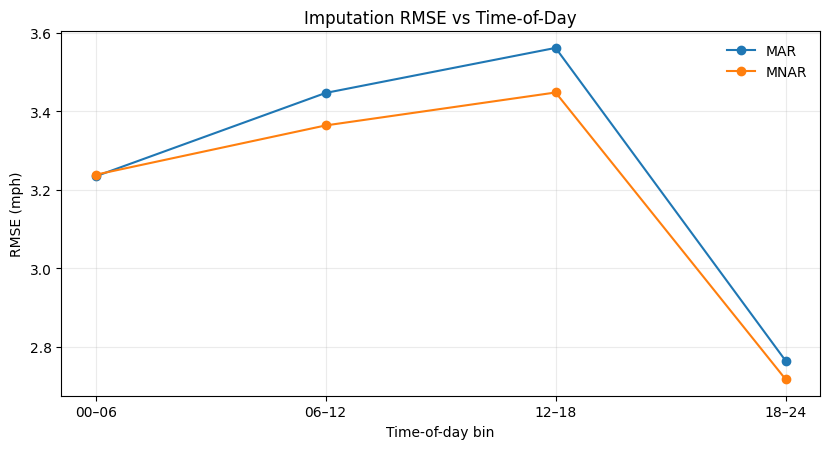


Worst 3 windows for MAR:


,window_id,detector_id,len_steps,tod,rmse_MAR
84,191,090es00769,24,12–18,15.075113
209,95,005es16920,24,18–24,14.734230
122,43,005es16097,12,06–12,10.724241


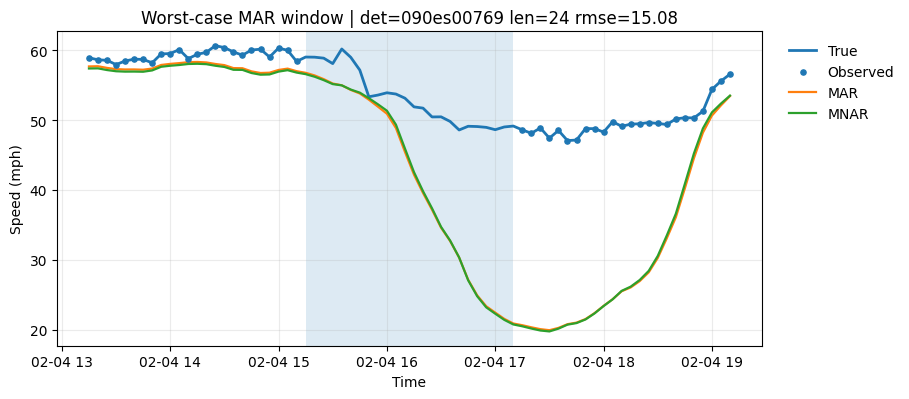

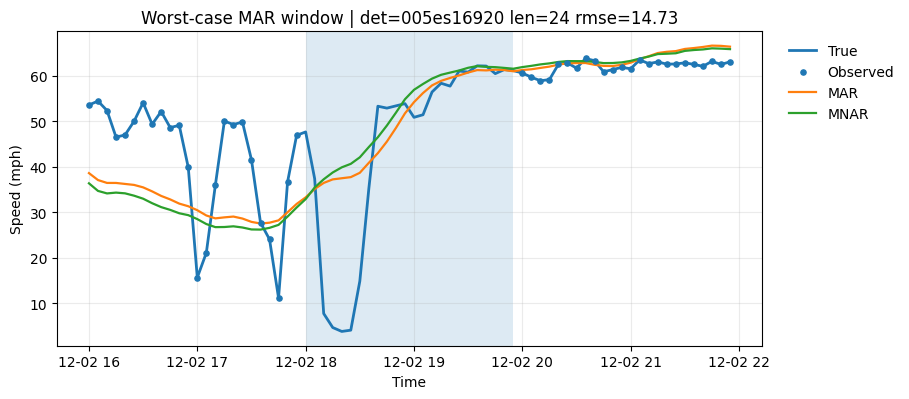

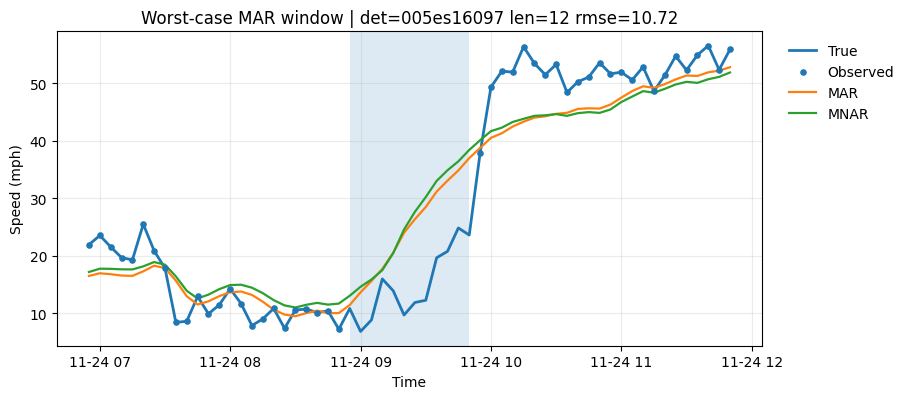


Worst 3 windows for MNAR:


,window_id,detector_id,len_steps,tod,rmse_MNAR
209,95,005es16920,24,18–24,15.687988
84,191,090es00769,24,12–18,15.078882
122,43,005es16097,12,06–12,11.844754


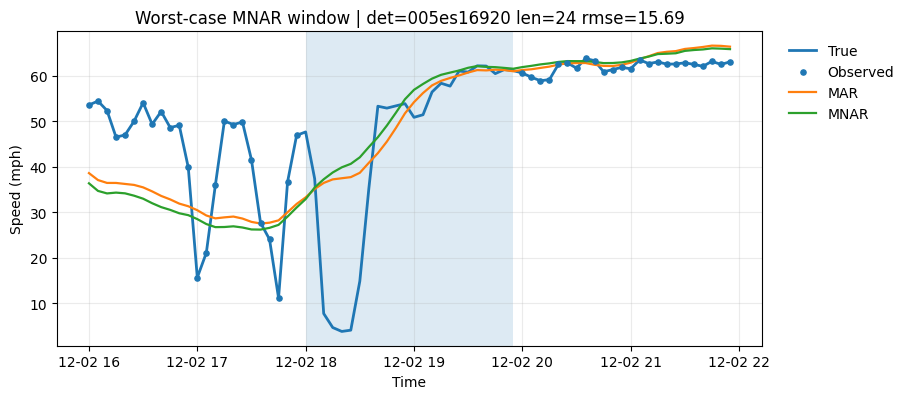

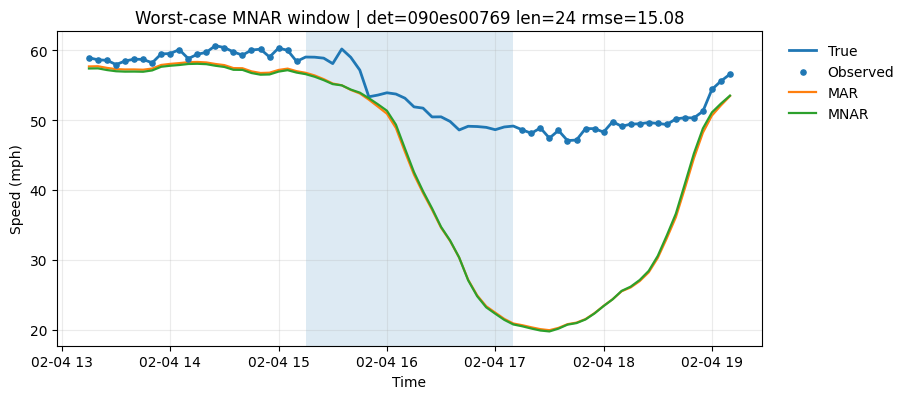

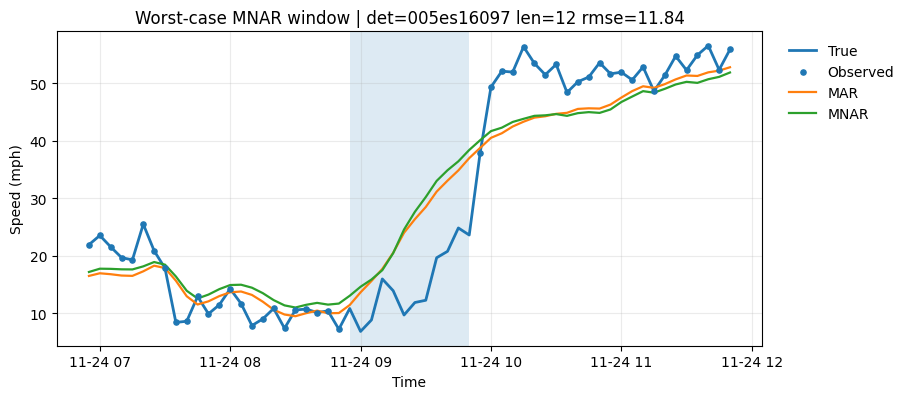

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def _tod_bin(ts):
    # ts can be numpy datetime64 or pandas Timestamp
    t = pd.to_datetime(ts)
    h = int(t.hour)
    if 0 <= h < 6:  return "00–06"
    if 6 <= h < 12: return "06–12"
    if 12 <= h < 18: return "12–18"
    return "18–24"

def _make_detector_groups(meta, detector_features, x_ref, m_ref, k=5, seed=0):
    """
    Returns group label per detector index.
    If detector_features exists -> cluster in that space.
    Else -> cluster using (mean_speed, missing_rate).
    """
    D = len(meta["detectors"])
    if detector_features is not None and isinstance(detector_features, np.ndarray) and detector_features.ndim == 2:
        X = detector_features.astype(float)
        X = np.nan_to_num(X, nan=0.0)
        km = KMeans(n_clusters=min(k, D), random_state=seed, n_init="auto").fit(X)
        return np.array([f"type{c}" for c in km.labels_], dtype=object)

    # fallback: simple 2D embedding per detector
    obs = (m_ref == 0) & np.isfinite(x_ref)
    mean_speed = np.nan_to_num((np.nansum(np.where(obs, x_ref, 0.0), axis=0) / (obs.sum(axis=0)+1e-6)), nan=0.0)
    miss_rate = np.mean(m_ref > 0, axis=0).astype(float)
    X = np.vstack([mean_speed, miss_rate]).T
    km = KMeans(n_clusters=min(k, D), random_state=seed, n_init="auto").fit(X)
    return np.array([f"type{c}" for c in km.labels_], dtype=object)

det_group = _make_detector_groups(meta, detector_features, x_t_train, m_t_train, k=5, seed=0)

def _window_rmse(x_true, x_pred, meta, w):
    s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
    e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
    d = np.where(meta["detectors"] == w["detector_id"])[0][0]
    y = x_true[s:e+1, d].astype(float)
    p = x_pred[s:e+1, d].astype(float)
    mask = np.isfinite(y) & np.isfinite(p)
    if not mask.any():
        return np.nan
    return float(np.sqrt(np.mean((y[mask] - p[mask])**2)))

# You already built these:
# recon_mar_full, recon_mnar_full, x_locf_full, x_lin_full
preds = {
    "LOCF": x_locf_full,
    "LinearInterp": x_lin_full,
    "MAR": recon_mar_full,
    "MNAR": recon_mnar_full,
}

rows = []
for w in impute_evaluation_windows_val:
    d_idx = np.where(meta["detectors"] == w["detector_id"])[0][0]
    rows.append({
        "window_id": w["window_id"],
        "detector_id": w["detector_id"],
        "detector_group": det_group[d_idx],
        "len_steps": int(w["len_steps"]),
        "tod": _tod_bin(w["blackout_start"]),
        "start_ts": pd.to_datetime(w["blackout_start"]),
    })
dfw = pd.DataFrame(rows)

# attach per-method RMSE
for name, xp in preds.items():
    dfw[f"rmse_{name}"] = [ _window_rmse(x_t, xp, meta, w) for w in impute_evaluation_windows_val ]

display(dfw.head())

def _group_report(df, group_cols, metric_col):
    g = df.groupby(group_cols)[metric_col].agg(["mean","median","count"]).reset_index()
    g = g.sort_values("mean")
    return g

# --- 1) RMSE vs blackout length buckets (more granular than your 4 bins) ---
dfw["len_bucket"] = pd.cut(dfw["len_steps"], bins=[0,6,24,72,288,1_000_000], labels=["1–6","7–24","25–72","73–288",">288"])
for method in ["MAR","MNAR","LOCF","LinearInterp"]:
    rep = _group_report(dfw, ["len_bucket"], f"rmse_{method}")
    print(f"\n=== Impute RMSE by length bucket: {method} ===")
    display(rep)

# --- 2) RMSE vs time-of-day ---
for method in ["MAR","MNAR","LOCF","LinearInterp"]:
    rep = _group_report(dfw, ["tod"], f"rmse_{method}")
    print(f"\n=== Impute RMSE by time-of-day: {method} ===")
    display(rep)

# --- 3) RMSE vs detector_group (proxy for sensor type) ---
for method in ["MAR","MNAR","LOCF","LinearInterp"]:
    rep = _group_report(dfw, ["detector_group"], f"rmse_{method}")
    print(f"\n=== Impute RMSE by detector_group: {method} ===")
    display(rep)

# --- Plots (no color hard-coding) ---
plt.figure(figsize=(8.4,4.6))
for method in ["MAR","MNAR"]:
    g = dfw.groupby("tod")[f"rmse_{method}"].mean()
    plt.plot(g.index.astype(str), g.values, marker="o", label=method)
plt.title("Imputation RMSE vs Time-of-Day")
plt.xlabel("Time-of-day bin")
plt.ylabel("RMSE (mph)")
plt.grid(True, alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- Worst-case window plots: show where each model fails ---
def plot_worst_windows(method, topk=3, pad=24):
    col = f"rmse_{method}"
    worst = dfw.sort_values(col, ascending=False).head(topk)
    print(f"\nWorst {topk} windows for {method}:")
    display(worst[["window_id","detector_id","len_steps","tod",col]])

    for _, r in worst.iterrows():
        w = next(ww for ww in impute_evaluation_windows_val if ww["window_id"] == r["window_id"])
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        a = max(0, s - pad)
        b = min(x_t.shape[0], e + pad + 1)

        plt.figure(figsize=(9.2, 4.1))
        plt.plot(meta["timestamps"][a:b], x_t[a:b, d], label="True", linewidth=2)
        obs_mask_seg = np.isfinite(x_t_train[a:b, d])
        plt.scatter(meta["timestamps"][a:b][obs_mask_seg], x_t_train[a:b, d][obs_mask_seg], s=14, label="Observed", zorder=3)

        plt.plot(meta["timestamps"][a:b], preds["MAR"][a:b, d], label="MAR", linewidth=1.6)
        plt.plot(meta["timestamps"][a:b], preds["MNAR"][a:b, d], label="MNAR", linewidth=1.6)

        plt.axvspan(meta["timestamps"][s], meta["timestamps"][e], alpha=0.15)
        plt.title(f"Worst-case {method} window | det={w['detector_id']} len={w['len_steps']} rmse={r[col]:.2f}")
        plt.ylabel("Speed (mph)")
        plt.xlabel("Time")
        plt.grid(True, alpha=0.25)
        plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.02,1.0))
        plt.tight_layout()
        plt.show()

plot_worst_windows("MAR", topk=3)
plot_worst_windows("MNAR", topk=3)



[MAR synth gamma=0.0] Imputation performance:
  MAE : 0.674886302639809
  MSE : 0.7225843585290513
  RMSE: 0.8500496212157567

[MAR synth gamma=0.0] Forecasting performance:
-----------------------------------
1-step MAE : 0.7941761887610852
1-step MSE : 0.9597366526210567
1-step RMSE: 0.9796614989990454

-----------------------------------
3-step MAE : 1.0074408214979198
3-step MSE : 1.5957150219160077
3-step RMSE: 1.2632161422005372

-----------------------------------
6-step MAE : 1.097115245639929
6-step MSE : 1.9845445766295637
6-step RMSE: 1.4087386473826733

[MNAR synth gamma=0.0] Imputation performance:
  MAE : 0.6401092363685907
  MSE : 0.6499647313878075
  RMSE: 0.8062039018683843

[MNAR synth gamma=0.0] Forecasting performance:
-----------------------------------
1-step MAE : 0.7787622651352476
1-step MSE : 0.8873595028064895
1-step RMSE: 0.9419976129515878

-----------------------------------
3-step MAE : 0.9659323838455791
3-step MSE : 1.4817460542452745
3-step RMSE: 1.21

,gamma,seed,model,impute_rmse,f_rmse_1,f_rmse_3,f_rmse_6
0,0.0,0,MAR,0.850050,0.979661,1.263216,1.408739
1,0.0,0,MNAR,0.806204,0.941998,1.217270,1.407928
2,0.0,1,MAR,0.826315,0.865252,1.138654,1.194229
3,0.0,1,MNAR,0.791869,0.833758,1.110146,1.156091
4,0.0,2,MAR,0.819760,0.930293,1.015906,1.115391
5,0.0,2,MNAR,0.797882,0.905491,1.002882,1.102082
6,0.5,0,MAR,0.853367,0.973169,1.248272,1.405122
7,0.5,0,MNAR,0.808162,0.933473,1.201178,1.402499
8,0.5,1,MAR,0.828400,0.860011,1.119935,1.190336
9,0.5,1,MNAR,0.791561,0.833010,1.090891,1.151209


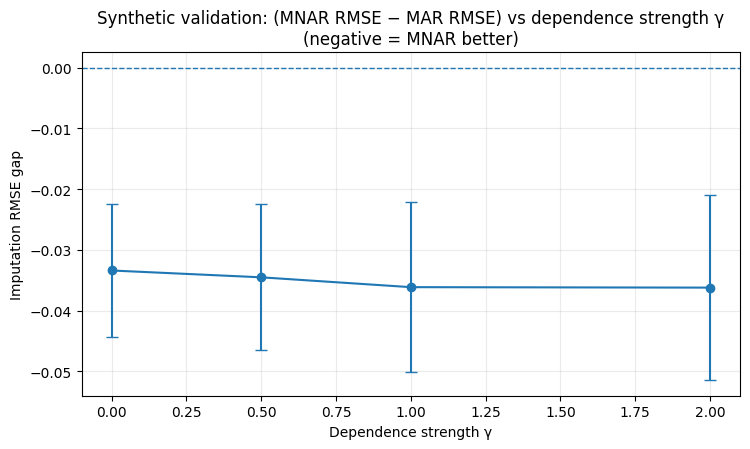

In [73]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

# ---------- Synthetic helpers ----------
def _stable_A(K, seed=0, scale=0.95):
    rs = np.random.default_rng(seed)
    A = rs.normal(size=(K,K)).astype(float)
    # scale spectral radius
    eig = max(abs(np.linalg.eigvals(A)))
    A = (scale / max(eig, 1e-6)) * A
    return A

def simulate_linear_ssm(T, D, K, seed=0):
    rs = np.random.default_rng(seed)
    A = _stable_A(K, seed=seed, scale=0.98)
    C = rs.normal(size=(D,K)).astype(float) / np.sqrt(K)
    Q = 0.15 * np.eye(K)
    R = 0.50 * np.eye(D)

    z = np.zeros((T,K), float)
    x = np.zeros((T,D), float)
    z[0] = rs.normal(size=K)
    x[0] = C @ z[0] + rs.multivariate_normal(np.zeros(D), R)
    for t in range(1,T):
        z[t] = A @ z[t-1] + rs.multivariate_normal(np.zeros(K), Q)
        x[t] = C @ z[t] + rs.multivariate_normal(np.zeros(D), R)
    return x, {"A":A, "C":C, "Q":Q, "R":R}

def build_time_feats_synth(T, period=288):
    # simple sin/cos daily cycle like 5-min data
    t = np.arange(T)
    w = 2*np.pi/period
    return np.stack([np.sin(w*t), np.cos(w*t)], axis=1).astype(float)

def sigmoid(u): 
    return 1.0/(1.0+np.exp(-u))

def calibrate_bias_for_missing_rate(score, target_rate=0.10, iters=40):
    # Find b so mean(sigmoid(b+score)) ~= target_rate
    lo, hi = -20.0, 20.0
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        p = sigmoid(mid + score).mean()
        if p > target_rate:
            hi = mid
        else:
            lo = mid
    return 0.5*(lo+hi)

def make_mnar_missingness(x, Xtime, gamma=0.0, target_rate=0.10, seed=0):
    """
    MNAR: p(missing[t,d]) depends on standardized x[t-1,d] + time features.
    gamma controls strength.
    """
    rs = np.random.default_rng(seed)
    T,D = x.shape
    x_std = (x - x.mean(axis=0, keepdims=True)) / (x.std(axis=0, keepdims=True)+1e-6)
    # use lagged signal (avoid peeking at same-time)
    lag = np.vstack([x_std[0:1], x_std[:-1]])

    # fixed time weights
    wt = np.array([0.6, -0.4], float) if Xtime.shape[1] >= 2 else np.ones((Xtime.shape[1],), float)*0.0
    time_score = Xtime @ wt  # (T,)

    score = gamma * lag + time_score[:,None]  # (T,D)

    b = calibrate_bias_for_missing_rate(score, target_rate=target_rate)
    p = sigmoid(b + score)
    m = (rs.uniform(size=(T,D)) < p).astype(np.uint8)  # 1=missing
    return m

def build_synth_meta(T, D):
    # timestamps as ints (works with your np.where equality usage)
    meta = {
        "timestamps": np.arange(T),
        "detectors": np.array([f"D{j}" for j in range(D)], dtype=object),
    }
    return meta

def sample_eval_windows_synth(meta, m_true, n_windows=200, len_choices=(6,12,24,48,72), seed=0):
    """
    Create impute + forecast(1/3/6) windows like your pipeline.
    Prefer segments that are mostly observed in m_true.
    """
    rs = np.random.default_rng(seed)
    T,D = m_true.shape
    windows = []
    wid = 0
    tries = 0
    while len([w for w in windows if w["test_type"]=="impute"]) < n_windows and tries < 50_000:
        tries += 1
        d = int(rs.integers(0,D))
        L = int(rs.choice(len_choices))
        s = int(rs.integers(20, T - (L+10)))
        e = s + L - 1

        seg = m_true[s:e+1, d]
        # accept if mostly observed originally (so we’re evaluating real reconstruction)
        if seg.mean() > 0.20:
            continue

        det_id = meta["detectors"][d]
        start_ts = meta["timestamps"][s]
        end_ts   = meta["timestamps"][e]

        impute_wid = f"w{wid}"
        windows.append({"window_id": impute_wid, "test_type":"impute", "blackout_start":start_ts, "blackout_end":end_ts, "detector_id":det_id, "len_steps":L})
        for h in [1,3,6]:
            windows.append({"window_id": impute_wid, "test_type":"forecast", "horizon_steps":h, "blackout_start":start_ts, "blackout_end":end_ts, "detector_id":det_id, "len_steps":L})
        wid += 1

    # split into aligned lists like you did
    imp = [w for w in windows if w["test_type"]=="impute"]
    f1  = [w for w in windows if w.get("horizon_steps",None)==1]
    f3  = [w for w in windows if w.get("horizon_steps",None)==3]
    f6  = [w for w in windows if w.get("horizon_steps",None)==6]
    return imp, f1, f3, f6, windows

# ---------- Run sweep ----------
def run_synth_sweep(gammas=(0.0, 0.5, 1.0, 2.0), seeds=(0,1,2), T=6000, D=25, K=10, miss_rate=0.10):
    all_rows = []
    for gamma in gammas:
        for seed in seeds:
            # synth data
            x_true, _ = simulate_linear_ssm(T=T, D=D, K=K, seed=seed)
            meta_s = build_synth_meta(T,D)
            Xtime_s = build_time_feats_synth(T)
            m_true = make_mnar_missingness(x_true, Xtime_s, gamma=gamma, target_rate=miss_rate, seed=seed)

            # choose eval windows + mask them (re-use your mask fn)
            imp_w, f1_w, f3_w, f6_w, all_w = sample_eval_windows_synth(meta_s, m_true, n_windows=200, seed=seed)

            x_train = x_true.copy()
            m_train = m_true.copy()
            a_train = np.zeros_like(m_train, dtype=np.uint8)

            # mask unique blocks (same idea as your mask_evaluation_windows)
            seen = set()
            for w in all_w:
                key = (w["blackout_start"], w["blackout_end"], w["detector_id"])
                if key in seen:
                    continue
                seen.add(key)
                s = int(w["blackout_start"]); e = int(w["blackout_end"])
                d = int(np.where(meta_s["detectors"] == w["detector_id"])[0][0])
                x_train[s:e+1, d] = np.nan
                m_train[s:e+1, d] = 1
                a_train[s:e+1, d] = 1

            # train MAR
            mar_params = mnar_blackout_lds.MNARParams.init_random(K=K, D=D, seed=seed)
            mar = mnar_blackout_lds.MNARBlackoutLDS(mar_params, use_missingness_obs=False)
            mar.em_train(x_train, m_train, num_iters=7, update_phi=False, phi_steps=0, phi_lr=0.0,
                         verbose=False, convergence_tol=1e-3, use_missingness_obs=False)

            # train MNAR warm-start
            mnar_params = copy.deepcopy(mar.params)
            # safe init
            for name in ["phi","phi_time","phi_det","bias_m"]:
                if hasattr(mnar_params, name) and getattr(mnar_params, name) is not None:
                    getattr(mnar_params, name)[:] = 0.0

            mnar = mnar_blackout_lds.MNARBlackoutLDS(mnar_params, use_missingness_obs=True, missingness_var_mode="moment", missingness_var_const=0.25)
            mnar.em_train(x_train, m_train, num_iters=7, update_phi=True, phi_steps=2, phi_lr=1e-4,
                          verbose=False, convergence_tol=1e-3, use_missingness_obs=True,
                          init_missingness_bias=True, init_phi_if_zero=True, init_phi_noise=1e-3, init_seed=seed)

            # smoother/recon
            ekf_mar = mar.ekf_forward(x_train, m_train)
            sm_mar  = mar.rts_smoother(ekf_mar)
            ekf_mnr = mnar.ekf_forward(x_train, m_train, a_t=a_train, X_time=Xtime_s, detector_features=None)
            sm_mnr  = mnar.rts_smoother(ekf_mnr)

            # reuse your evaluator by passing windows explicitly
            met_mar = evaluate_impute_forecast_model(
                model=mar,
                mu_smooth=sm_mar["mu_smooth"], Sigma_smooth=sm_mar["Sigma_smooth"],
                mu_filt=ekf_mar["mu_filt"], Sigma_filt=ekf_mar["Sigma_filt"],
                x_t=x_true, meta=meta_s, label=f"MAR synth gamma={gamma}",
                impute_windows=imp_w, forecast_windows=(f1_w+f3_w+f6_w)
            )
            met_mnr = evaluate_impute_forecast_model(
                model=mnar,
                mu_smooth=sm_mnr["mu_smooth"], Sigma_smooth=sm_mnr["Sigma_smooth"],
                mu_filt=ekf_mnr["mu_filt"], Sigma_filt=ekf_mnr["Sigma_filt"],
                x_t=x_true, meta=meta_s, label=f"MNAR synth gamma={gamma}",
                impute_windows=imp_w, forecast_windows=(f1_w+f3_w+f6_w)
            )

            for name, met in [("MAR", met_mar), ("MNAR", met_mnr)]:
                all_rows.append({
                    "gamma": gamma, "seed": seed, "model": name,
                    "impute_rmse": met["impute_rmse"],
                    "f_rmse_1": met["forecast_rmse_1"],
                    "f_rmse_3": met["forecast_rmse_3"],
                    "f_rmse_6": met["forecast_rmse_6"],
                })

    df = pd.DataFrame(all_rows)
    return df

df_synth = run_synth_sweep(gammas=(0.0, 0.5, 1.0, 2.0), seeds=(0,1,2), T=6000, D=25, K=10, miss_rate=0.10)
display(df_synth)

# Plot: MNAR - MAR gap vs gamma (should flip positive as gamma increases)
pivot = df_synth.pivot_table(index=["gamma","seed"], columns="model", values="impute_rmse").reset_index()
pivot["gap_mnar_minus_mar"] = pivot["MNAR"] - pivot["MAR"]

g = pivot.groupby("gamma")["gap_mnar_minus_mar"].agg(["mean","std"]).reset_index()
plt.figure(figsize=(7.6,4.6))
plt.errorbar(g["gamma"], g["mean"], yerr=g["std"], marker="o", capsize=4)
plt.axhline(0.0, linestyle="--", linewidth=1.0)
plt.title("Synthetic validation: (MNAR RMSE − MAR RMSE) vs dependence strength γ\n(negative = MNAR better)")
plt.xlabel("Dependence strength γ")
plt.ylabel("Imputation RMSE gap")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


In [74]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

def _gp_fit_predict(t_train, y_train, t_pred, kernel):
    # fixed hyperparams (optimizer=None) for speed + reproducibility
    gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=0.0, normalize_y=True)
    gp.fit(t_train[:,None], y_train)
    mu, std = gp.predict(t_pred[:,None], return_std=True)
    return mu.astype(float), (std.astype(float)**2)

# Kernel: smooth + periodic + noise
GP_KERNEL = (1.0 * RBF(length_scale=96.0)) + (0.5 * ExpSineSquared(length_scale=96.0, periodicity=288.0)) + WhiteKernel(noise_level=1.0)

def gp_impute_baseline(x_masked, start_idx, end_idx, detector_idx, context=288, max_points=400):
    """
    Offline imputation can use both sides of the blackout (like smoothing).
    """
    T = x_masked.shape[0]
    a = max(0, start_idx - context)
    b = min(T, end_idx + context + 1)

    t = np.arange(a, b)
    y = x_masked[a:b, detector_idx].astype(float)

    obs = np.isfinite(y)
    t_obs = t[obs]
    y_obs = y[obs]
    if y_obs.size < 20:
        # fallback
        return linear_interp_impute_baseline(x_masked, start_idx, end_idx, detector_idx)

    # subsample for speed
    if y_obs.size > max_points:
        idx = np.linspace(0, y_obs.size-1, max_points).astype(int)
        t_obs = t_obs[idx]
        y_obs = y_obs[idx]

    t_pred = np.arange(start_idx, end_idx+1)
    mu, _ = _gp_fit_predict(t_obs, y_obs, t_pred, GP_KERNEL)
    return mu

def gp_forecast_baseline(x_masked, target_idx, detector_idx, context=2016, max_points=600):
    """
    Causal forecast: only uses data up to target_idx-1.
    """
    a = max(0, target_idx - context)
    t = np.arange(a, target_idx)
    y = x_masked[a:target_idx, detector_idx].astype(float)

    obs = np.isfinite(y)
    t_obs = t[obs]
    y_obs = y[obs]
    if y_obs.size < 30:
        return seasonal_naive_forecast_baseline(x_masked, target_idx, detector_idx)

    if y_obs.size > max_points:
        idx = np.linspace(0, y_obs.size-1, max_points).astype(int)
        t_obs = t_obs[idx]
        y_obs = y_obs[idx]

    mu, _ = _gp_fit_predict(t_obs, y_obs, np.array([target_idx]), GP_KERNEL)
    return float(mu[0])

# ---- Evaluate GP on a SUBSET of windows (adjust n_sub for runtime vs fidelity) ----
n_sub = 150  # increase if you want a stronger estimate
rs = np.random.default_rng(0)
imp_sub = list(rs.choice(impute_evaluation_windows_val, size=min(n_sub, len(impute_evaluation_windows_val)), replace=False))

# Keep aligned forecast windows for those ids
sub_ids = set([w["window_id"] for w in imp_sub])
f_sub = [w for w in (forecast_1_evaluation_windows_val+forecast_3_evaluation_windows_val+forecast_6_evaluation_windows_val) if w["window_id"] in sub_ids]

metrics_gp = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=gp_impute_baseline,
    forecast_fn=gp_forecast_baseline,
    label=f"LocalGP (subsample n={len(imp_sub)})",
)
print(metrics_gp)



[LocalGP (subsample n=150)] Imputation performance:
  MAE : 4.684091875588126
  MSE : 54.699890620867556
  RMSE: 7.39593744030245

[LocalGP (subsample n=150)] Forecasting performance:
-----------------------------------
1-step MAE : 5.5833551979160445
1-step MSE : 70.05744671921907
1-step RMSE: 8.37003265938784

-----------------------------------
3-step MAE : 5.208547469304532
3-step MSE : 63.16353301298967
3-step RMSE: 7.947548868235392

-----------------------------------
6-step MAE : 4.85289747111141
6-step MSE : 52.84132007054828
6-step RMSE: 7.269203537565053
{'impute_mae': np.float64(4.684091875588126), 'impute_mse': np.float64(54.699890620867556), 'impute_rmse': 7.39593744030245, 'forecast_mae_1': 5.5833551979160445, 'forecast_mse_1': 70.05744671921907, 'forecast_rmse_1': 8.37003265938784, 'forecast_mae_3': 5.208547469304532, 'forecast_mse_3': 63.16353301298967, 'forecast_rmse_3': 7.947548868235392, 'forecast_mae_6': 4.85289747111141, 'forecast_mse_6': 52.84132007054828, 'fore

In [75]:
import copy
import pandas as pd

def run_inference_variant(name, model_base, x_train, m_train, a_train, X_time_use, det_feat_use, zero_phi=False):
    # copy params so we can zero-out phi without affecting main model
    params = copy.deepcopy(model_base.params)
    if zero_phi and hasattr(params, "phi") and params.phi is not None:
        params.phi[:] = 0.0

    model = mnar_blackout_lds.MNARBlackoutLDS(params, use_missingness_obs=True,
                                             missingness_var_mode="moment", missingness_var_const=0.25)

    ekf = model.ekf_forward(x_train, m_train, a_t=a_train, X_time=X_time_use, detector_features=det_feat_use)
    sm  = model.rts_smoother(ekf)

    met = evaluate_impute_forecast_model(
        model=model,
        mu_smooth=sm["mu_smooth"], Sigma_smooth=sm["Sigma_smooth"],
        mu_filt=ekf["mu_filt"], Sigma_filt=ekf["Sigma_filt"],
        x_t=x_t, meta=meta, label=name
    )
    return met

ablations = []
ablations.append(("MNAR-full", dict(Xt=X_time, Df=detector_features, zero_phi=False)))
ablations.append(("no-time",   dict(Xt=None,  Df=detector_features, zero_phi=False)))
ablations.append(("no-det",    dict(Xt=X_time, Df=None,             zero_phi=False)))
ablations.append(("time+det only (phi=0)", dict(Xt=X_time, Df=detector_features, zero_phi=True)))
ablations.append(("no-time no-det", dict(Xt=None, Df=None, zero_phi=False)))

rows = []
for name, cfg in ablations:
    met = run_inference_variant(name, model_mnar, x_t_train, m_t_train, a_t_train, cfg["Xt"], cfg["Df"], zero_phi=cfg["zero_phi"])
    rows.append({
        "variant": name,
        "impute_rmse": met["impute_rmse"],
        "f_rmse_1": met["forecast_rmse_1"],
        "f_rmse_3": met["forecast_rmse_3"],
        "f_rmse_6": met["forecast_rmse_6"],
    })

df_ablate_inf = pd.DataFrame(rows).sort_values("impute_rmse")
display(df_ablate_inf)



[MNAR-full] Imputation performance:
  MAE : 2.804270564411956
  MSE : 17.60101029265599
  RMSE: 4.1953558004841485

[MNAR-full] Forecasting performance:
-----------------------------------
1-step MAE : 3.003637040964912
1-step MSE : 18.599692325850086
1-step RMSE: 4.312736060304419

-----------------------------------
3-step MAE : 3.0412510633063983
3-step MSE : 17.87716408381466
3-step RMSE: 4.228139553493316

-----------------------------------
6-step MAE : 3.3840678112935367
6-step MSE : 26.054450621705982
6-step RMSE: 5.1043560437831905

[no-time] Imputation performance:
  MAE : 2.804270564411956
  MSE : 17.60101029265599
  RMSE: 4.1953558004841485

[no-time] Forecasting performance:
-----------------------------------
1-step MAE : 3.003637040964912
1-step MSE : 18.599692325850086
1-step RMSE: 4.312736060304419

-----------------------------------
3-step MAE : 3.0412510633063983
3-step MSE : 17.87716408381466
3-step RMSE: 4.228139553493316

-----------------------------------
6-st

,variant,impute_rmse,f_rmse_1,f_rmse_3,f_rmse_6
0,MNAR-full,4.195356,4.312736,4.228140,5.104356
1,no-time,4.195356,4.312736,4.228140,5.104356
2,no-det,4.195356,4.312736,4.228140,5.104356
4,no-time no-det,4.195356,4.312736,4.228140,5.104356
3,time+det only (phi=0),4.196824,4.300653,4.219635,5.086265


In [76]:
import itertools
import pandas as pd
import copy

def train_mnar_with_knobs(num_iters=10, phi_steps=2, phi_lr=1e-4, seed=0):
    # warm-start from your trained MAR (best practice)
    params = copy.deepcopy(model_mar.params)
    for name in ["phi","phi_time","phi_det","bias_m"]:
        if hasattr(params, name) and getattr(params, name) is not None:
            getattr(params, name)[:] = 0.0

    model = mnar_blackout_lds.MNARBlackoutLDS(
        params,
        use_missingness_obs=True,
        missingness_var_mode="moment",
        missingness_var_const=0.25,
    )
    model.em_train(
        x_t_train, m_t_train,
        num_iters=num_iters,
        update_phi=True,
        phi_steps=phi_steps,
        phi_lr=phi_lr,
        verbose=False,
        convergence_tol=1e-3,
        use_missingness_obs=True,
        init_missingness_bias=True,
        init_phi_if_zero=True,
        init_phi_noise=1e-3,
        init_seed=seed,
    )

    ekf = model.ekf_forward(x_t_train, m_t_train, a_t=a_t_train, X_time=X_time, detector_features=detector_features)
    sm  = model.rts_smoother(ekf)
    met = evaluate_impute_forecast_model(
        model=model,
        mu_smooth=sm["mu_smooth"], Sigma_smooth=sm["Sigma_smooth"],
        mu_filt=ekf["mu_filt"], Sigma_filt=ekf["Sigma_filt"],
        x_t=x_t, meta=meta,
        label=f"MNAR train ablate iters={num_iters} steps={phi_steps} lr={phi_lr}"
    )
    return met

grid = {
    "num_iters": [5, 10],
    "phi_steps": [1, 2],
    "phi_lr":    [1e-5, 1e-4],
}
rows = []
for num_iters, phi_steps, phi_lr in itertools.product(grid["num_iters"], grid["phi_steps"], grid["phi_lr"]):
    met = train_mnar_with_knobs(num_iters=num_iters, phi_steps=phi_steps, phi_lr=phi_lr, seed=0)
    rows.append({
        "num_iters": num_iters, "phi_steps": phi_steps, "phi_lr": phi_lr,
        "impute_rmse": met["impute_rmse"],
        "f_rmse_1": met["forecast_rmse_1"],
        "f_rmse_3": met["forecast_rmse_3"],
        "f_rmse_6": met["forecast_rmse_6"],
    })

df_train_ablate = pd.DataFrame(rows).sort_values("impute_rmse")
display(df_train_ablate)



[MNAR train ablate iters=5 steps=1 lr=1e-05] Imputation performance:
  MAE : 2.842034945019629
  MSE : 17.86586180889288
  RMSE: 4.226802788029373

[MNAR train ablate iters=5 steps=1 lr=1e-05] Forecasting performance:
-----------------------------------
1-step MAE : 3.0722581577482244
1-step MSE : 18.98673435530543
1-step RMSE: 4.357377004036422

-----------------------------------
3-step MAE : 3.0786098425363555
3-step MSE : 18.373172726091102
3-step RMSE: 4.286393907014508

-----------------------------------
6-step MAE : 3.4033679363206346
6-step MSE : 26.24610814044458
6-step RMSE: 5.123095562298695

[MNAR train ablate iters=5 steps=1 lr=0.0001] Imputation performance:
  MAE : 2.841881204633103
  MSE : 17.858908614752238
  RMSE: 4.225980195735924

[MNAR train ablate iters=5 steps=1 lr=0.0001] Forecasting performance:
-----------------------------------
1-step MAE : 3.0723000826904485
1-step MSE : 19.009084145771887
1-step RMSE: 4.359940842003695

----------------------------------

,num_iters,phi_steps,phi_lr,impute_rmse,f_rmse_1,f_rmse_3,f_rmse_6
7,10,2,0.00010,4.195356,4.312736,4.228140,5.104356
5,10,1,0.00010,4.196448,4.295625,4.214524,5.097301
6,10,2,0.00001,4.199108,4.285639,4.207313,5.094617
4,10,1,0.00001,4.199526,4.284583,4.206606,5.094511
3,5,2,0.00010,4.225324,4.362954,4.289292,5.127608
1,5,1,0.00010,4.225980,4.359941,4.287700,5.125021
2,5,2,0.00001,4.226699,4.357657,4.286533,5.123289
0,5,1,0.00001,4.226803,4.357377,4.286394,5.123096


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _diag_from_cov(cov):
    """
    cov can be:
      - (T,D) -> already diag variances
      - (T,D,D) -> take diag
      - (D,D) -> diag
      - None -> returns None
    """
    if cov is None:
        return None
    cov = np.asarray(cov)
    if cov.ndim == 2:
        # could be (T,D) or (D,D)
        if cov.shape[0] == cov.shape[1]:
            return np.diag(cov)[None, :]  # (1,D)
        return cov  # (T,D)
    if cov.ndim == 3:
        return np.diagonal(cov, axis1=-2, axis2=-1)  # (T,D)
    return None

def _gauss_nll(y, mu, var, eps=1e-6):
    var = np.maximum(var, eps)
    return 0.5 * (np.log(2*np.pi*var) + ((y-mu)**2)/var)

def _z_for_level(level):
    # central interval level -> z
    # 0.50,0.80,0.90,0.95,0.99 approximate
    z_map = {0.50: 0.674, 0.80: 1.282, 0.90: 1.645, 0.95: 1.960, 0.99: 2.576}
    return z_map.get(level, 1.960)

def imputation_prob_metrics(model, mu_smooth, Sigma_smooth, x_true, meta, windows, label="model"):
    recon_mu, recon_cov = model.reconstruct_from_smoother(mu_smooth, Sigma_smooth)
    recon_var = _diag_from_cov(recon_cov)  # (T,D) if available

    levels = [0.80, 0.90, 0.95]
    nlls = []
    cover = {lv: [] for lv in levels}

    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        yt = x_true[s:e+1, d].astype(float)
        mu = recon_mu[s:e+1, d].astype(float)

        mask = np.isfinite(yt) & np.isfinite(mu)
        if not mask.any():
            continue

        if recon_var is None:
            # fallback: use global R diag if present, else constant
            # try common names
            R = None
            for nm in ["R", "Sigma_x", "R_x", "obs_cov"]:
                if hasattr(model.params, nm):
                    R = getattr(model.params, nm)
                    break
            if R is not None:
                R = np.asarray(R)
                if R.ndim == 2 and R.shape[0] == R.shape[1]:
                    var = float(np.diag(R)[d])
                else:
                    var = float(np.mean(R))
            else:
                var = float(np.nanvar(x_true[:, d]) + 1e-6)
            var_vec = np.full(mu.shape, var, dtype=float)
        else:
            var_vec = recon_var[s:e+1, d].astype(float)

        # NLL per point
        nll = _gauss_nll(yt[mask], mu[mask], var_vec[mask])
        nlls.extend(list(nll))

        # coverage
        for lv in levels:
            z = _z_for_level(lv)
            lo = mu - z*np.sqrt(np.maximum(var_vec, 1e-6))
            hi = mu + z*np.sqrt(np.maximum(var_vec, 1e-6))
            cov = np.mean((yt[mask] >= lo[mask]) & (yt[mask] <= hi[mask]))
            cover[lv].append(float(cov))

    out = {
        "label": label,
        "impute_nll_mean": float(np.mean(nlls)) if len(nlls) else np.nan,
        "impute_nll_median": float(np.median(nlls)) if len(nlls) else np.nan,
    }
    for lv in levels:
        out[f"impute_cov_{int(lv*100)}"] = float(np.mean(cover[lv])) if len(cover[lv]) else np.nan

    return out

def forecast_prob_metrics(model, mu_filt, Sigma_filt, x_true, meta, forecast_windows, label="model"):
    levels = [0.80, 0.90, 0.95]
    nlls = []
    cover = {lv: [] for lv in levels}

    for w in forecast_windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue

        yt = float(x_true[target_idx, d])
        if not np.isfinite(yt):
            continue

        mu_vec, cov = model.k_step_forecast(mu_filt, Sigma_filt, end_idx, k=h)
        mu = float(mu_vec[d]) if np.isfinite(mu_vec[d]) else np.nan
        if not np.isfinite(mu):
            continue

        # extract variance for detector d
        var = None
        if cov is not None:
            cov = np.asarray(cov)
            if cov.ndim == 2 and cov.shape[0] == cov.shape[1]:
                var = float(np.diag(cov)[d])
            elif cov.ndim == 1 and cov.shape[0] == mu_vec.shape[0]:
                var = float(cov[d])
        if var is None or not np.isfinite(var):
            # fallback on measurement noise if we can find it
            R = None
            for nm in ["R", "Sigma_x", "R_x", "obs_cov"]:
                if hasattr(model.params, nm):
                    R = getattr(model.params, nm)
                    break
            if R is not None:
                R = np.asarray(R)
                if R.ndim == 2 and R.shape[0] == R.shape[1]:
                    var = float(np.diag(R)[d])
                else:
                    var = float(np.mean(R))
            else:
                var = float(np.nanvar(x_true[:, d]) + 1e-6)

        nlls.append(float(_gauss_nll(np.array([yt]), np.array([mu]), np.array([var]))[0]))

        for lv in levels:
            z = _z_for_level(lv)
            lo = mu - z*np.sqrt(max(var, 1e-6))
            hi = mu + z*np.sqrt(max(var, 1e-6))
            cover[lv].append(float((yt >= lo) and (yt <= hi)))

    out = {
        "label": label,
        "forecast_nll_mean": float(np.mean(nlls)) if len(nlls) else np.nan,
        "forecast_nll_median": float(np.median(nlls)) if len(nlls) else np.nan,
    }
    for lv in levels:
        out[f"forecast_cov_{int(lv*100)}"] = float(np.mean(cover[lv])) if len(cover[lv]) else np.nan
    return out

forecast_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

rows = []
rows.append(imputation_prob_metrics(model_mar,  mu_smooth_mar,  Sigma_smooth_mar,  x_t, meta, impute_evaluation_windows_val, label="MAR"))
rows.append(imputation_prob_metrics(model_mnar, mu_smooth_mnar, Sigma_smooth_mnar, x_t, meta, impute_evaluation_windows_val, label="MNAR"))

rows.append(forecast_prob_metrics(model_mar,  mu_filt_mar,  Sigma_filt_mar,  x_t, meta, forecast_windows_val, label="MAR"))
rows.append(forecast_prob_metrics(model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val, label="MNAR"))

prob_df = pd.DataFrame(rows)
display(prob_df)

prob_df.to_csv(os.path.join(FIG_DIR, "probabilistic_metrics_coverage_nll.csv"), index=False)
print("Saved:", os.path.join(FIG_DIR, "probabilistic_metrics_coverage_nll.csv"))


,label,impute_nll_mean,impute_nll_median,impute_cov_80,impute_cov_90,impute_cov_95,forecast_nll_mean,forecast_nll_median,forecast_cov_80,forecast_cov_90,forecast_cov_95
0,MAR,2.826630,2.480417,0.843472,0.901250,0.936250,NaN,NaN,NaN,NaN,NaN
1,MNAR,2.804178,2.484775,0.845556,0.909861,0.944444,NaN,NaN,NaN,NaN,NaN
2,MAR,NaN,NaN,NaN,NaN,NaN,2.936032,2.617493,0.832222,0.901111,0.940000
3,MNAR,NaN,NaN,NaN,NaN,NaN,2.909776,2.618036,0.845556,0.913333,0.941111


Saved: figures\probabilistic_metrics_coverage_nll.csv


[detector clustering] K=2 groups
Saved: figures\impute_failure_mode_table.csv


,window_id,detector_id,len_steps,len_bucket,hour_bucket,dow,det_group,method,rmse
0,367,405es02808,12,7–24,18-23,6,0,LOCF,1.059476
1,367,405es02808,12,7–24,18-23,6,0,LinearInterp,0.709311
2,367,405es02808,12,7–24,18-23,6,0,MAR,0.714898
3,367,405es02808,12,7–24,18-23,6,0,MNAR,0.668233
4,77,005es16583,24,7–24,12-17,3,1,LOCF,5.388875


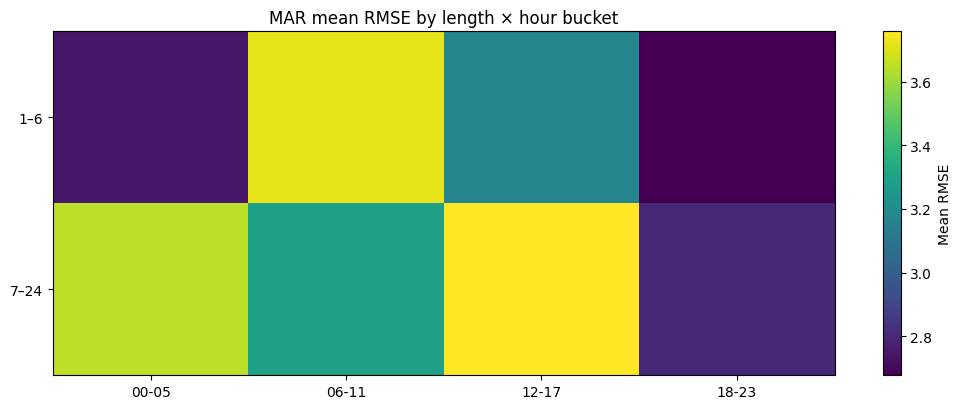

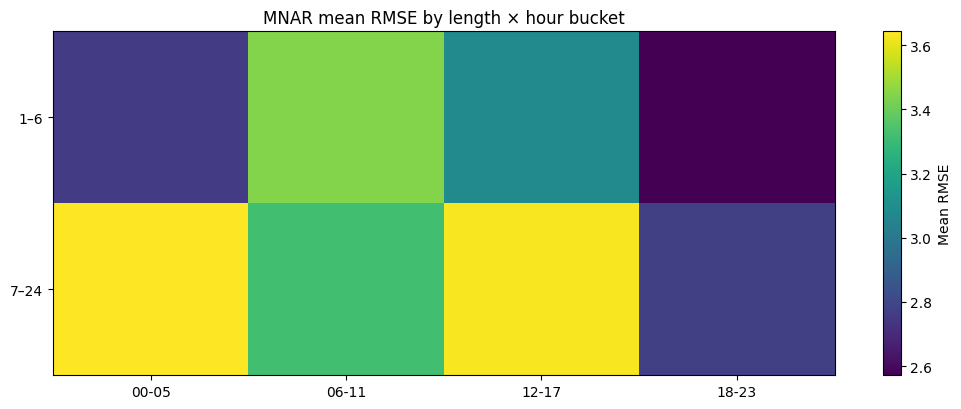

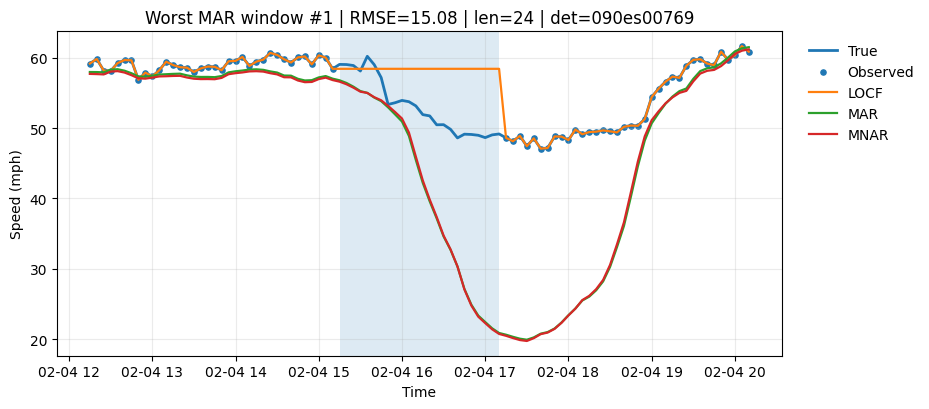

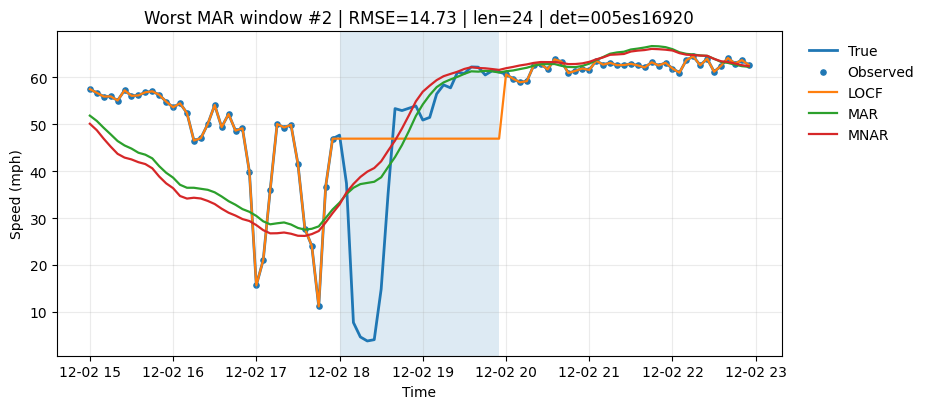

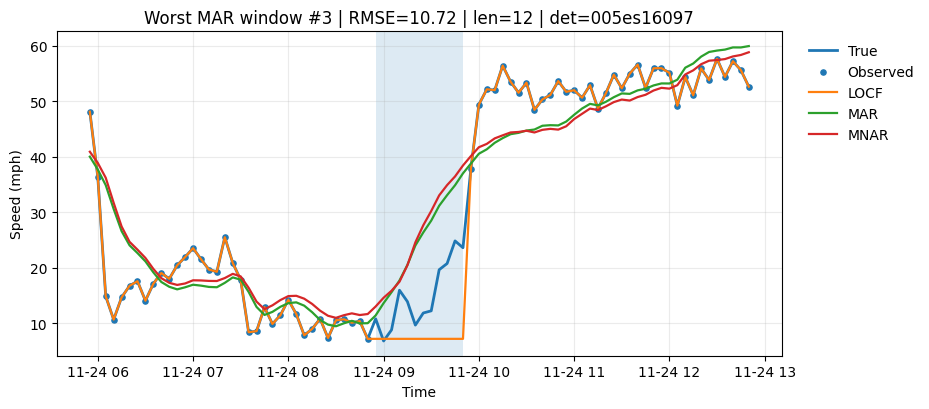

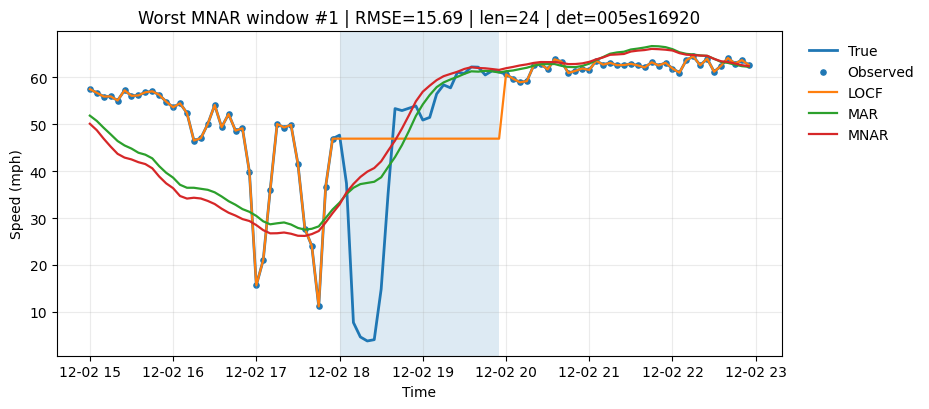

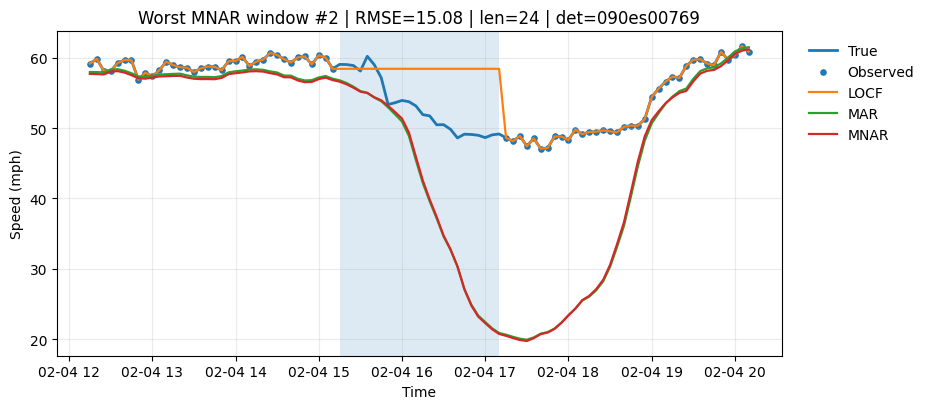

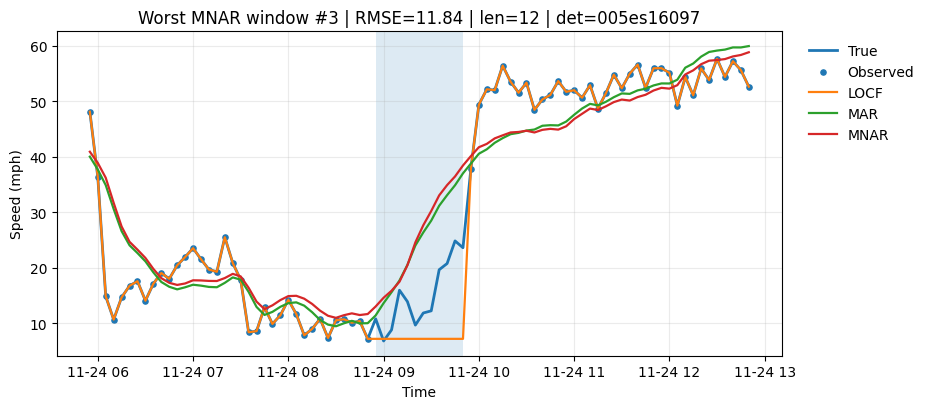

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _window_hour(ts):
    t = pd.to_datetime(ts)
    return int(t.hour)

def _window_dow(ts):
    t = pd.to_datetime(ts)
    return int(t.dayofweek)

def _bucket_hour(h):
    # simple bins: night, morning, afternoon, evening
    if 0 <= h < 6: return "00-05"
    if 6 <= h < 12: return "06-11"
    if 12 <= h < 18: return "12-17"
    return "18-23"

def _bucket_len(L):
    if L <= 6: return "1–6"
    if L <= 24: return "7–24"
    if L <= 72: return "25–72"
    return "73+"

# ---- detector "type": if you have detector_features, cluster into K groups (numeric, easy)
det_group = None
if detector_features is not None:
    from sklearn.cluster import KMeans
    Xdet = np.asarray(detector_features, float)
    # sanitize
    Xdet = np.nan_to_num(Xdet, nan=0.0, posinf=0.0, neginf=0.0)
    K = min(6, max(2, Xdet.shape[0] // 50))  # heuristic
    km = KMeans(n_clusters=K, random_state=0, n_init=10).fit(Xdet)
    det_group = km.labels_
    print(f"[detector clustering] K={K} groups")
else:
    print("[detector clustering] detector_features not found; will skip detector-type stratification.")

# ---- build per-window RMSE for each method (imputation windows only)
methods = {
    "LOCF": x_locf_full,
    "LinearInterp": x_lin_full,
    "MAR": recon_mar_full,
    "MNAR": recon_mnar_full,
}

rows = []
worst = {m: [] for m in methods.keys()}

for w in impute_evaluation_windows_val:
    s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
    e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
    d = np.where(meta["detectors"] == w["detector_id"])[0][0]

    yt = x_t[s:e+1, d].astype(float)
    mask_true = np.isfinite(yt)
    if not mask_true.any():
        continue

    hour = _bucket_hour(_window_hour(w["blackout_start"]))
    dow = _window_dow(w["blackout_start"])
    lenb = _bucket_len(int(w["len_steps"]))
    dg = int(det_group[d]) if det_group is not None else -1

    base = {
        "window_id": w["window_id"],
        "detector_id": w["detector_id"],
        "len_steps": int(w["len_steps"]),
        "len_bucket": lenb,
        "hour_bucket": hour,
        "dow": dow,
        "det_group": dg,
    }

    for name, xpred in methods.items():
        yp = xpred[s:e+1, d].astype(float)
        mask = mask_true & np.isfinite(yp)
        if not mask.any():
            continue
        rmse = float(np.sqrt(np.mean((yp[mask] - yt[mask])**2)))
        r = dict(base)
        r["method"] = name
        r["rmse"] = rmse
        rows.append(r)
        worst[name].append((rmse, w))

df = pd.DataFrame(rows)
df.to_csv(os.path.join(FIG_DIR, "impute_failure_mode_table.csv"), index=False)
print("Saved:", os.path.join(FIG_DIR, "impute_failure_mode_table.csv"))
display(df.head())

# ---- Heatmap: (len_bucket × hour_bucket) for MAR vs MNAR (mean RMSE, counts)
def _pivot(method):
    sub = df[df["method"] == method]
    piv = sub.pivot_table(index="len_bucket", columns="hour_bucket", values="rmse", aggfunc="mean")
    cnt = sub.pivot_table(index="len_bucket", columns="hour_bucket", values="rmse", aggfunc="count")
    return piv, cnt

p_mar, c_mar = _pivot("MAR")
p_mnar, c_mnar = _pivot("MNAR")

plt.figure(figsize=(10.5, 4.2))
plt.imshow(p_mar.values, aspect="auto")
plt.xticks(range(p_mar.shape[1]), list(p_mar.columns))
plt.yticks(range(p_mar.shape[0]), list(p_mar.index))
plt.colorbar(label="Mean RMSE")
plt.title("MAR mean RMSE by length × hour bucket")
plt.tight_layout()
_savefig("heatmap_mar_len_hour_rmse")
plt.show()

plt.figure(figsize=(10.5, 4.2))
plt.imshow(p_mnar.values, aspect="auto")
plt.xticks(range(p_mnar.shape[1]), list(p_mnar.columns))
plt.yticks(range(p_mnar.shape[0]), list(p_mnar.index))
plt.colorbar(label="Mean RMSE")
plt.title("MNAR mean RMSE by length × hour bucket")
plt.tight_layout()
_savefig("heatmap_mnar_len_hour_rmse")
plt.show()

# ---- Worst-case windows: plot top-3 for MAR and MNAR
def plot_worst_windows(which="MAR", topk=3, pad=36):
    pairs = sorted(worst[which], key=lambda z: -z[0])[:topk]
    for j, (rmse, w) in enumerate(pairs, 1):
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        a = max(0, s-pad)
        b = min(x_t.shape[0], e+pad+1)

        plt.figure(figsize=(9.4, 4.2))
        plt.plot(meta["timestamps"][a:b], x_t[a:b, d], label="True", linewidth=2)
        obs_mask_seg = np.isfinite(x_t_train[a:b, d])
        plt.scatter(meta["timestamps"][a:b][obs_mask_seg], x_t_train[a:b, d][obs_mask_seg], s=14, label="Observed")

        # methods
        for mname in ["LOCF","MAR","MNAR"]:
            plt.plot(meta["timestamps"][a:b], methods[mname][a:b, d], label=mname, linewidth=1.6)

        plt.axvspan(meta["timestamps"][s], meta["timestamps"][e], alpha=0.15)
        plt.title(f"Worst {which} window #{j} | RMSE={rmse:.2f} | len={w['len_steps']} | det={w['detector_id']}")
        plt.xlabel("Time"); plt.ylabel("Speed (mph)")
        plt.grid(True, alpha=0.25)
        plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))
        plt.tight_layout()
        _savefig(f"worst_{which.lower()}_{j}")
        plt.show()

plot_worst_windows("MAR", topk=3)
plot_worst_windows("MNAR", topk=3)


In [79]:
import numpy as np
import pandas as pd

def per_window_rmse(x_true, x_pred, meta, windows):
    vals = []
    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        yt = x_true[s:e+1, d].astype(float)
        yp = x_pred[s:e+1, d].astype(float)
        mask = np.isfinite(yt) & np.isfinite(yp)
        if not mask.any():
            continue
        rmse = float(np.sqrt(np.mean((yp[mask]-yt[mask])**2)))
        vals.append((w["window_id"], rmse, int(w["len_steps"])))
    return vals

# compute matched per-window rmse lists for MAR/MNAR
mar_list  = per_window_rmse(x_t, recon_mar_full,  meta, impute_evaluation_windows_val)
mnar_list = per_window_rmse(x_t, recon_mnar_full, meta, impute_evaluation_windows_val)

df_mar  = pd.DataFrame(mar_list,  columns=["window_id","rmse_mar","len_steps"])
df_mnar = pd.DataFrame(mnar_list, columns=["window_id","rmse_mnar","len_steps"])

pw = df_mar.merge(df_mnar, on=["window_id","len_steps"], how="inner")
pw["delta"] = pw["rmse_mnar"] - pw["rmse_mar"]  # negative is good (MNAR better)
display(pw.head())

improved = float(np.mean(pw["delta"] < 0))
print(f"% windows where MNAR improves over MAR: {improved*100:.1f}%  (N={len(pw)})")

# paired bootstrap CI for mean delta
rs = np.random.default_rng(0)
B = 3000
d = pw["delta"].to_numpy()
stats = np.empty(B)
n = len(d)
for b in range(B):
    idx = rs.integers(0, n, size=n)
    stats[b] = float(np.mean(d[idx]))
center = float(np.mean(d))
lo, hi = float(np.quantile(stats, 0.025)), float(np.quantile(stats, 0.975))
p_boot = float(2 * min(np.mean(stats <= 0), np.mean(stats >= 0)))  # two-sided around 0

print(f"Mean (MNAR - MAR) RMSE delta: {center:.4f}  95% CI [{lo:.4f}, {hi:.4f}]  bootstrap p~{p_boot:.4f}")

pw.to_csv(os.path.join(FIG_DIR, "paired_window_deltas_mar_vs_mnar.csv"), index=False)
print("Saved:", os.path.join(FIG_DIR, "paired_window_deltas_mar_vs_mnar.csv"))


,window_id,rmse_mar,len_steps,rmse_mnar,delta
0,367,0.714898,12,0.668233,-0.046665
1,77,7.327140,24,5.549430,-1.777710
2,0,4.802426,6,4.781450,-0.020976
3,398,3.798900,24,4.062038,0.263138
4,131,1.597913,24,1.503854,-0.094059


% windows where MNAR improves over MAR: 52.1%  (N=420)
Mean (MNAR - MAR) RMSE delta: -0.0584  95% CI [-0.1079, -0.0150]  bootstrap p~0.0120
Saved: figures\paired_window_deltas_mar_vs_mnar.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# ----------------------------
# Numerically-stable sigmoid
# ----------------------------
def sigmoid(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x, dtype=float)
    pos = x >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-x[pos]))
    ex = np.exp(x[~pos])
    out[~pos] = ex / (1.0 + ex)
    return out

def make_spd(M, eps=1e-6, force_diag=False):
    M = np.asarray(M, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"make_spd expects square matrix, got {M.shape}")
    if force_diag:
        d = np.diag(M).copy()
        d = np.maximum(d, eps)
        return np.diag(d)
    M = 0.5 * (M + M.T)
    w = np.linalg.eigvalsh(M)
    wmin = float(w.min())
    if wmin < eps:
        M = M + (eps - wmin + eps) * np.eye(M.shape[0])
    return M

def stabilize_A(A, max_rho=0.98):
    """
    Scale A down if spectral radius > max_rho.
    This prevents latent blow-ups -> prevents phi@mu overflow -> prevents NaNs.
    """
    A = np.asarray(A, dtype=float)
    eig = np.linalg.eigvals(A)
    rho = float(np.max(np.abs(eig)))
    if not np.isfinite(rho) or rho <= 0:
        return A
    if rho > max_rho:
        A = A * (max_rho / (rho + 1e-12))
    return A

def simulate_lgssm(A, C, Q, R, T=4000, seed=0):
    rs = np.random.default_rng(seed)
    K = A.shape[0]
    D = C.shape[0]
    z = np.zeros((T, K), dtype=float)
    x = np.zeros((T, D), dtype=float)
    z[0] = rs.multivariate_normal(np.zeros(K), np.eye(K))
    for t in range(T):
        if t > 0:
            z[t] = A @ z[t-1] + rs.multivariate_normal(np.zeros(K), Q)
        x[t] = C @ z[t] + rs.multivariate_normal(np.zeros(D), R)
    return z, x

def make_blackouts_from_hazard(z, alpha, target_missing_frac=0.10, mean_len=24, seed=0):
    rs = np.random.default_rng(seed)
    T, K = z.shape
    p_end = 1.0 / max(mean_len, 2)

    def rollout(bias):
        m = np.zeros(T, dtype=np.uint8)
        t = 1
        while t < T-1:
            if m[t] == 1:
                t += 1
                continue
            h = float(sigmoid(bias + alpha * z[t, 0]))
            if rs.random() < h:
                L = 1
                while (t+L) < T and (rs.random() > p_end):
                    L += 1
                    if L > 500:
                        break
                m[t+1:min(T, t+1+L)] = 1
                t = t + 1 + L
            else:
                t += 1
        return m

    lo, hi = -10.0, 2.0
    best_m = None
    for _ in range(25):
        mid = 0.5*(lo+hi)
        rs = np.random.default_rng(seed)  # reset per eval
        m = rollout(mid)
        frac = m.mean()
        best_m = m
        if frac > target_missing_frac:
            hi = mid
        else:
            lo = mid
    return best_m

def extract_blocks(m):
    blocks = []
    T = len(m)
    t = 0
    while t < T:
        if m[t] == 1:
            s = t
            while t < T and m[t] == 1:
                t += 1
            e = t - 1
            blocks.append((s, e))
        else:
            t += 1
    return blocks

def build_synth_windows(blocks, det_id, timestamps):
    out = []
    for i, (s, e) in enumerate(blocks):
        out.append({
            "window_id": f"synth_{det_id}_{i}",
            "test_type": "impute",
            "blackout_start": timestamps[s],
            "blackout_end": timestamps[e],
            "detector_id": det_id,
            "len_steps": int(e - s + 1),
        })
    return out

def fit_phi_via_logreg(mu_feat, m, seed=0, C=0.25):
    """
    Fit phi,bias per detector using L2-regularized logistic regression:
      P(m_t,d=1 | z_t) = sigmoid(bias[d] + phi[d] @ z_t)

    mu_feat: (T, K) latent features (use MAR smoothed means)
    m      : (T, D) missingness indicators
    """
    rs = np.random.default_rng(seed)
    T, K = mu_feat.shape
    D = m.shape[1]

    phi = np.zeros((D, K), dtype=float)
    bias = np.zeros(D, dtype=float)

    X = np.asarray(mu_feat, dtype=float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    for d in range(D):
        y = m[:, d].astype(int)
        # If degenerate (all 0/1), keep phi=0 and set bias to logit(p)
        p = float(np.clip(y.mean(), 1e-4, 1-1e-4))
        if y.min() == y.max():
            bias[d] = float(np.log(p/(1-p)))
            continue

        clf = LogisticRegression(
            penalty="l2",
            C=C,                     # stronger reg (smaller C) keeps phi small
            solver="lbfgs",
            max_iter=200,
            random_state=seed,
        )
        clf.fit(X, y)
        phi[d, :] = clf.coef_.reshape(-1)
        bias[d] = float(clf.intercept_[0])

        # Hard safety clamp (prevents any downstream overflow)
        phi[d, :] = np.clip(phi[d, :], -2.0, 2.0)
        bias[d] = float(np.clip(bias[d], -6.0, 6.0))

    return phi, bias

def safe_weighted_rmse(se_list, w_list):
    if len(se_list) == 0:
        return np.nan
    w = np.asarray(w_list, dtype=float)
    if not np.isfinite(w).all() or w.sum() <= 0:
        return np.nan
    se = np.asarray(se_list, dtype=float)
    if not np.isfinite(se).all():
        return np.nan
    return float(np.sqrt(np.average(se, weights=w)))

def run_synth(alpha, seed=0, T=3200, D_use=8, K_use=8, em_iters=6):
    # --- take sub-dimensions from your fitted MAR params ---
    A = np.asarray(model_mar.params.A)[:K_use, :K_use]
    C = np.asarray(model_mar.params.C)[:D_use, :K_use]
    Q = np.asarray(model_mar.params.Q)[:K_use, :K_use]
    Rfull = np.asarray(model_mar.params.R)

    if Rfull.ndim == 2 and Rfull.shape[0] == Rfull.shape[1]:
        R = Rfull[:D_use, :D_use]
    else:
        R = np.eye(D_use) * float(np.mean(Rfull))

    # --- CRITICAL: stabilize dynamics + covariances (prevents latent blowups) ---
    A = stabilize_A(A, max_rho=0.98)
    Q = make_spd(Q, eps=1e-4, force_diag=False)
    R = make_spd(R, eps=1e-3, force_diag=True)

    # simulate clean
    z, x = simulate_lgssm(A, C, Q, R, T=T, seed=seed)

    # missingness per detector
    m = np.zeros((T, D_use), dtype=np.uint8)
    all_windows = []
    timestamps = np.arange(T)

    for d in range(D_use):
        md = make_blackouts_from_hazard(z, alpha=alpha, target_missing_frac=0.10, mean_len=24, seed=seed+10+d)
        m[:, d] = md
        all_windows.extend(build_synth_windows(extract_blocks(md), det_id=d, timestamps=timestamps))

    x_mask = x.copy()
    x_mask[m == 1] = np.nan

    # ----------------
    # 1) Fit MAR (EM)
    # ----------------
    mar_params = mnar_blackout_lds.MNARParams.init_random(K=K_use, D=D_use, seed=seed)
    mar_params.Q = make_spd(np.asarray(mar_params.Q), eps=1e-4, force_diag=False)
    mar_params.R = make_spd(np.asarray(mar_params.R), eps=1e-3, force_diag=True)

    mar = mnar_blackout_lds.MNARBlackoutLDS(mar_params, use_missingness_obs=False)
    mar.em_train(
        x_mask, m,
        num_iters=em_iters,
        update_phi=False,
        phi_steps=0,
        phi_lr=0.0,
        verbose=False,
        convergence_tol=1e-3,
        use_missingness_obs=False
    )

    # MAR inference (for recon + features)
    ekf_mar = mar.ekf_forward(x_mask, m)
    sm_mar = mar.rts_smoother(ekf_mar)
    recon_mar, _ = mar.reconstruct_from_smoother(sm_mar["mu_smooth"], sm_mar["Sigma_smooth"])

    # -----------------------------------------
    # 2) Fit MNAR phi via stable logistic reg
    # -----------------------------------------
    mu_feat = sm_mar["mu_smooth"]  # (T,K)
    phi_hat, bias_hat = fit_phi_via_logreg(mu_feat, m, seed=seed, C=0.25)

    # -----------------------------------------
    # 3) MNAR inference with FIXED phi (no EM)
    # -----------------------------------------
    mnar_params = copy.deepcopy(mar.params)
    if hasattr(mnar_params, "phi") and mnar_params.phi is not None:
        mnar_params.phi[:] = 0.0
        mnar_params.phi[:D_use, :K_use] = phi_hat
    if hasattr(mnar_params, "bias_m") and mnar_params.bias_m is not None:
        mnar_params.bias_m[:] = 0.0
        mnar_params.bias_m[:D_use] = bias_hat

    # keep safe
    if hasattr(mnar_params, "Q") and mnar_params.Q is not None:
        mnar_params.Q = make_spd(np.asarray(mnar_params.Q), eps=1e-4, force_diag=False)
    if hasattr(mnar_params, "R") and mnar_params.R is not None:
        mnar_params.R = make_spd(np.asarray(mnar_params.R), eps=1e-3, force_diag=True)

    mnar = mnar_blackout_lds.MNARBlackoutLDS(mnar_params, use_missingness_obs=True)

    # inference + recon (no training, so no blowups)
    ekf_mnar = mnar.ekf_forward(x_mask, m)
    sm_mnar = mnar.rts_smoother(ekf_mnar)
    recon_mnar, _ = mnar.reconstruct_from_smoother(sm_mnar["mu_smooth"], sm_mnar["Sigma_smooth"])

    # --------------------------
    # Weighted RMSE on blackouts
    # --------------------------
    se_mar, se_mnar, wts = [], [], []
    for w in all_windows:
        s = int(w["blackout_start"])
        e = int(w["blackout_end"])
        d = int(w["detector_id"])

        yt = x[s:e+1, d]
        marp = recon_mar[s:e+1, d]
        mnarp = recon_mnar[s:e+1, d]

        mask = np.isfinite(yt) & np.isfinite(marp) & np.isfinite(mnarp)
        if not mask.any():
            continue

        se_mar.append(float(np.mean((marp[mask] - yt[mask])**2)))
        se_mnar.append(float(np.mean((mnarp[mask] - yt[mask])**2)))
        wts.append(int(w["len_steps"]))

    rmse_mar = safe_weighted_rmse(se_mar, wts)
    rmse_mnar = safe_weighted_rmse(se_mnar, wts)
    return rmse_mar, rmse_mnar


# ---------------- Run sweep ----------------
alphas = [0.0, 0.4, 0.8, 1.2]
rep_seeds = [0, 1, 2]
rows = []

for a in alphas:
    for sd in rep_seeds:
        rmar, rmnar = run_synth(alpha=a, seed=sd, T=3200, D_use=8, K_use=8, em_iters=6)
        rows.append({"alpha": a, "seed": sd, "rmse_mar": rmar, "rmse_mnar": rmnar, "delta": (rmnar - rmar) if np.isfinite(rmar) and np.isfinite(rmnar) else np.nan})
        print(f"alpha={a:.1f} seed={sd}  MAR={rmar:.3f}  MNAR={rmnar:.3f}  (MNAR-MAR)={(rmnar-rmar):+.3f}" if np.isfinite(rmar) and np.isfinite(rmnar) else f"alpha={a:.1f} seed={sd}  MAR={rmar}  MNAR={rmnar}")

sdf = pd.DataFrame(rows)
display(sdf)

g = sdf.groupby("alpha")["delta"].agg(["mean", "std", "count"]).reset_index()

plt.figure(figsize=(7.2, 4.4))
plt.errorbar(g["alpha"], g["mean"], yerr=g["std"]/np.sqrt(g["count"]), marker="o", capsize=3)
plt.axhline(0, linewidth=1)
plt.xlabel("MNAR dependence strength α (hazard uses α·zₜ,0)")
plt.ylabel("Δ RMSE = MNAR − MAR (lower is better)")
plt.title("Synthetic validation: MNAR advantage increases with true dependence")
plt.grid(True, alpha=0.25)
plt.tight_layout()
_savefig("synthetic_validation_alpha_sweep")
plt.show()

sdf.to_csv(os.path.join(FIG_DIR, "synthetic_validation_alpha_sweep.csv"), index=False)
print("Saved:", os.path.join(FIG_DIR, "synthetic_validation_alpha_sweep.csv"))


alpha=0.0 seed=0  MAR=8.024  MNAR=4.160  (MNAR-MAR)=-3.864
alpha=0.0 seed=1  MAR=3.895  MNAR=3.683  (MNAR-MAR)=-0.212


c:\Users\Dell\Downloads\Modeling-Information-Blackouts-in-MNAR-Time-Series-main (2) (1)\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\mnar_blackout_lds.py:306: RuntimeWarning: overflow encountered in matmul
  u_m = bias_m[keep_idx] + (phi_k @ mu_t_pred)
c:\Users\Dell\Downloads\Modeling-Information-Blackouts-in-MNAR-Time-Series-main (2) (1)\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\mnar_blackout_lds.py:306: RuntimeWarning: invalid value encountered in matmul
  u_m = bias_m[keep_idx] + (phi_k @ mu_t_pred)


ZeroDivisionError: Weights sum to zero, can't be normalized

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
import numpy as np
import pandas as pd

def gp_local_impute_forecast(x_t_true, x_t_masked, meta, impute_windows, forecast_windows,
                             context=288*2, max_train=350, seed=0):
    """
    Fits a 1D GP per window on local context excluding blackout interval.
    Kernel = RBF + daily periodic + white noise.
    Uses SAME masked panel for training points (no peeking).

    NOTE: optimizer=None disables hyperparameter fitting => avoids ConvergenceWarning spam
          and makes the baseline deterministic given the seed + subsampling.
    """
    rs = np.random.default_rng(seed)

    def fit_predict_for_window(s, e, d, target_idxs):
        T = x_t_masked.shape[0]
        a = max(0, s - context)
        b = min(T, e + context + 1)

        y = x_t_masked[a:b, d].astype(float)
        t = np.arange(a, b).astype(float)

        # remove blackout region and NaNs
        keep = np.isfinite(y)
        keep[(s-a):(e-a+1)] = False
        t_train = t[keep].reshape(-1,1)
        y_train = y[keep]

        if len(y_train) < 20:
            return {ti: np.nan for ti in target_idxs}

        # subsample to limit cubic cost
        if len(y_train) > max_train:
            idx = rs.choice(len(y_train), size=max_train, replace=False)
            t_train = t_train[idx]
            y_train = y_train[idx]

        kernel = (
            1.0 * RBF(length_scale=120.0)
            + 0.8 * ExpSineSquared(length_scale=120.0, periodicity=288.0)
            + WhiteKernel(noise_level=1.0)
        )

        gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=1e-4,            # <<< jitter for stability
            normalize_y=True,
            optimizer=None,        # <<< disables hyperparam optimization => no warnings
            random_state=seed
        )
        gp.fit(t_train, y_train)

        preds = gp.predict(np.array(target_idxs, float).reshape(-1,1), return_std=False)
        return {ti: float(p) for ti, p in zip(target_idxs, preds)}

    # imputation errors (weighted)
    impute_mse = []
    impute_w = []

    for w in impute_windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        target = list(range(s, e+1))
        pred_map = fit_predict_for_window(s, e, d, target)

        yt = x_t_true[s:e+1, d].astype(float)
        yp = np.array([pred_map[i] for i in target], float)
        mask = np.isfinite(yt) & np.isfinite(yp)
        if not mask.any():
            continue
        impute_mse.append(float(np.mean((yp[mask]-yt[mask])**2)))
        impute_w.append(int(w["len_steps"]))

    impute_rmse = float(np.sqrt(np.average(impute_mse, weights=impute_w)))

    # forecast errors
    se = {1: [], 3: [], 6: []}
    for w in forecast_windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_t_true.shape[0]:
            continue

        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = end_idx
        pred_map = fit_predict_for_window(s, e, d, [target_idx])

        yt = float(x_t_true[target_idx, d])
        yp = float(pred_map[target_idx])
        if np.isfinite(yt) and np.isfinite(yp):
            se[h].append((yp-yt)**2)

    out = {
        "impute_rmse": impute_rmse,
        "forecast_rmse_1": float(np.sqrt(np.mean(se[1]))) if len(se[1]) else np.nan,
        "forecast_rmse_3": float(np.sqrt(np.mean(se[3]))) if len(se[3]) else np.nan,
        "forecast_rmse_6": float(np.sqrt(np.mean(se[6]))) if len(se[6]) else np.nan,
    }
    return out

forecast_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

gp_metrics = gp_local_impute_forecast(
    x_t_true=x_t, x_t_masked=x_t_train, meta=meta,
    impute_windows=impute_evaluation_windows_val,
    forecast_windows=forecast_windows_val,
    context=288*2, max_train=350, seed=0
)

print("GP baseline metrics:", gp_metrics)
pd.DataFrame([{"method":"LocalGP", **gp_metrics}]).to_csv(os.path.join(FIG_DIR, "gp_baseline_metrics.csv"), index=False)
print("Saved:", os.path.join(FIG_DIR, "gp_baseline_metrics.csv"))


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

GP baseline metrics: {'impute_rmse': 5.70989129747774, 'forecast_rmse_1': 3.080282361431664, 'forecast_rmse_3': 3.2753070334552725, 'forecast_rmse_6': 3.3929588534026847}
Saved: figures\gp_baseline_metrics.csv


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [86]:
import json, os

gp_run_info = {
    "method": "LocalGP",
    "seed": 0,
    "context": 288*2,
    "max_train": 350,
    "kernel": "Const*RBF(ls=120) + Const*ExpSineSquared(ls=120, period=288) + White(noise=1)",
    "optimizer": "None",
    "alpha_jitter": 1e-4,
    "normalize_y": True,
    "train_points_min": 20,
}

with open(os.path.join(FIG_DIR, "gp_baseline_run_info.json"), "w") as f:
    json.dump(gp_run_info, f, indent=2)

print("Saved:", os.path.join(FIG_DIR, "gp_baseline_run_info.json"))

Saved: figures\gp_baseline_run_info.json


In [ ]:
import numpy as np
import pandas as pd
import os

seeds = [0, 1, 2, 3, 4]
rows = []

for sd in seeds:
    m = gp_local_impute_forecast(
        x_t_true=x_t,
        x_t_masked=x_t_train,
        meta=meta,
        impute_windows=impute_evaluation_windows_val,
        forecast_windows=forecast_windows_val,
        context=288*2,
        max_train=350,
        seed=sd,
    )
    rows.append({"seed": sd, **m})
    print(sd, m)

df = pd.DataFrame(rows)
summary = df.drop(columns=["seed"]).agg(["mean", "std"]).T.reset_index().rename(columns={"index":"metric"})
display(df)
display(summary)

df.to_csv(os.path.join(FIG_DIR, "gp_baseline_seeds.csv"), index=False)
summary.to_csv(os.path.join(FIG_DIR, "gp_baseline_summary.csv"), index=False)

print("Saved:", os.path.join(FIG_DIR, "gp_baseline_seeds.csv"))
print("Saved:", os.path.join(FIG_DIR, "gp_baseline_summary.csv"))


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

0 {'impute_rmse': 5.70989129747774, 'forecast_rmse_1': 3.080282361431664, 'forecast_rmse_3': 3.2753070334552725, 'forecast_rmse_6': 3.3929588534026847}


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

1 {'impute_rmse': 5.517778267093283, 'forecast_rmse_1': 3.5731364141421373, 'forecast_rmse_3': 3.3774622793233355, 'forecast_rmse_6': 3.531936929902765}


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be